# Sub data to Previous Application
The goal of this Notebook is to aggregate data from Credit Card Balance, Pos_Cash Balance and Instalment Payments, creating a feature with encoded information of client behavior.

In [63]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


pd.plotting.register_matplotlib_converters()
%matplotlib inline
import duckdb



# Reload modules before executing code
%load_ext autoreload
%autoreload 2

from help_tool import help_tool, help_visuals, help_stats, help_model


import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='featuretools.computational_backends.feature_set_calculator')


pd.set_option('future.no_silent_downcasting', True)


sns.set_theme(style='whitegrid')
sns.set_palette('husl')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
application_train = help_tool.csv_download(
    r'Archive\home-credit-default-risk\application_train.csv')[['SK_ID_CURR', 'TARGET', 'EXT_SOURCE_1']]

# Pos_Cash Balance
Pos_Cash Balance describes monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
* This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans.
* These is ~10 mill. observations and 8 features, no duplicates. Null values for CNT_INSTALMENT and CNT_INSTALMENT_FUTURE seam to be related.

In [19]:
pos_cash = help_tool.csv_download(
    r'Archive\home-credit-default-risk\POS_CASH_balance.csv')
help_tool.first_look(pos_cash)

Dataset has 10001358 observations and 8 features
Columns with all empty values []
Dataset has 0 duplicates


dtypes Null values, Count Null values, %
SK_ID_PREV               int64                  0            0.0
SK_ID_CURR               int64                  0            0.0
MONTHS_BALANCE           int64                  0            0.0
CNT_INSTALMENT         float64              26071            0.3
CNT_INSTALMENT_FUTURE  float64              26087            0.3
NAME_CONTRACT_STATUS    object                  0            0.0
SK_DPD                   int64                  0            0.0
SK_DPD_DEF               int64                  0            0.0

## Null values

When CNT_INSTALMENT is misisng, SK_DPD and SK_DPD_DEF have values 0

In [5]:
pos_cash[pos_cash['CNT_INSTALMENT'].isna() & pos_cash['CNT_INSTALMENT_FUTURE'].isna()][[
    'SK_DPD', 'SK_DPD_DEF']].value_counts()

SK_DPD  SK_DPD_DEF
0       0             25974
Name: count, dtype: int64

Null values will be dropped

In [20]:
pos_cash = pos_cash[pos_cash['CNT_INSTALMENT'].notna(
) & pos_cash['CNT_INSTALMENT_FUTURE'].notna()]

## EDA
### Numerical Features

MONTHS_BALANCE


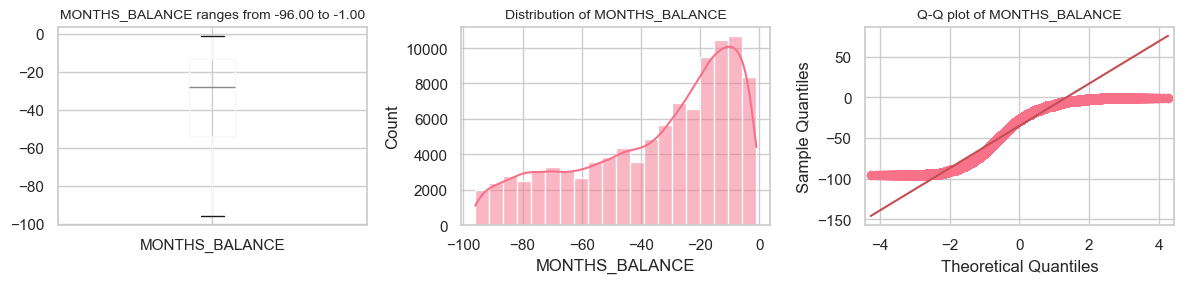

CNT_INSTALMENT


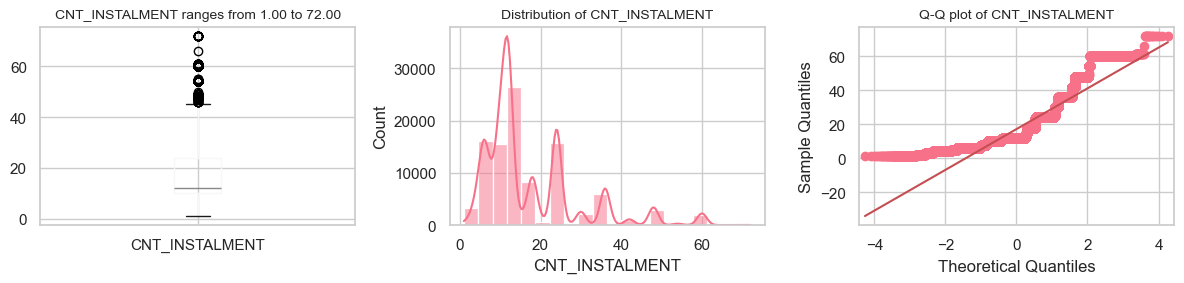

SK_DPD


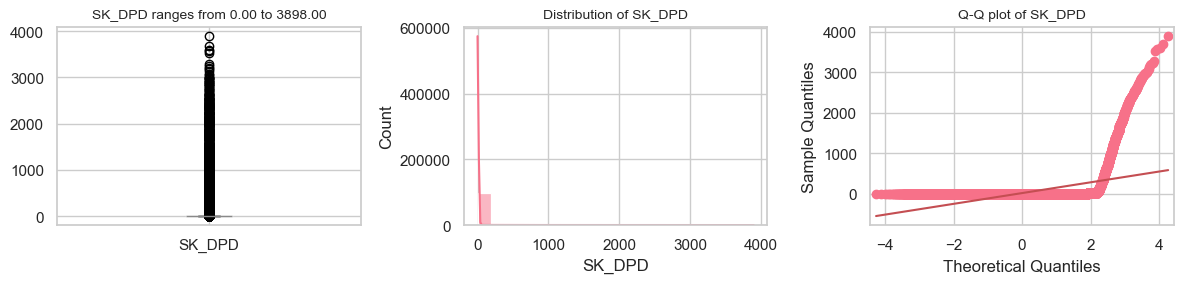

CARD_ACTIVITY


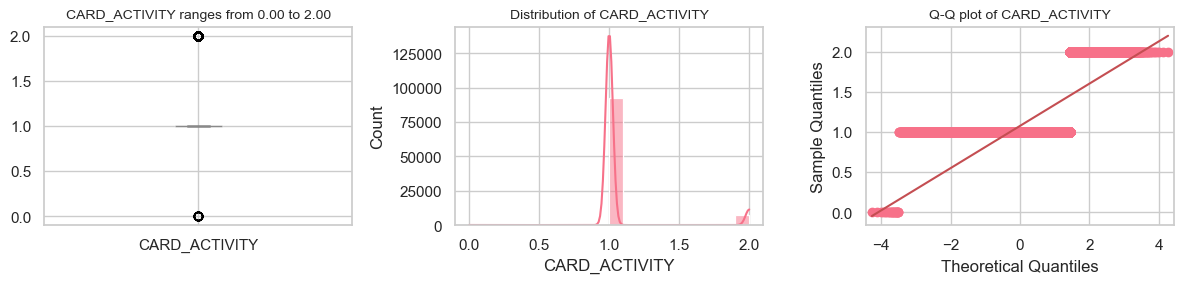

RISK_PROFILE


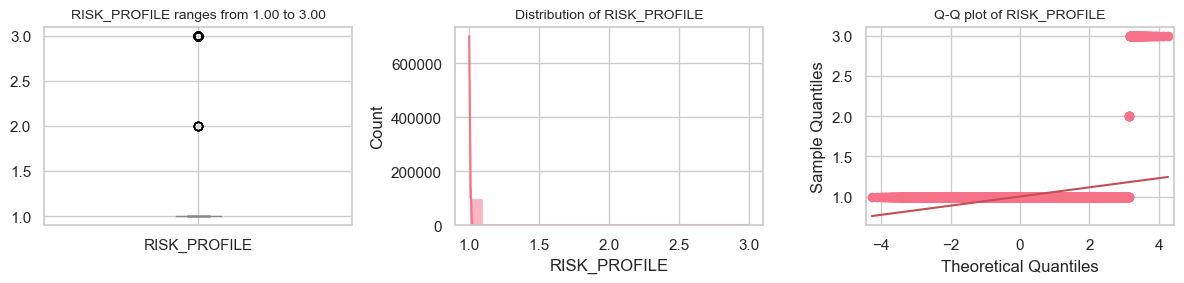

RATIO_Term_Payed_Left


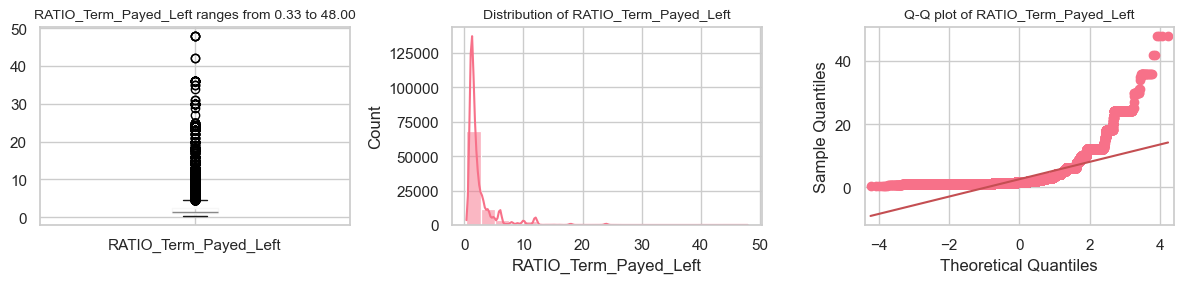

RATIO_DPD


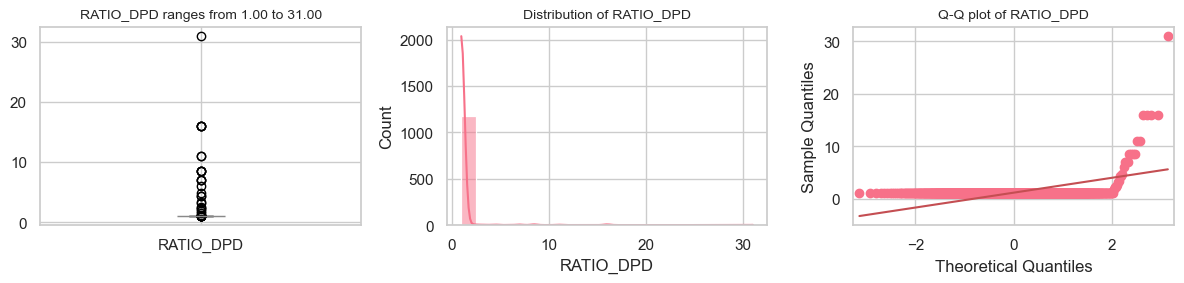

In [18]:
pos_cash_sample = pos_cash.sample(100000, random_state=42)
help_visuals.distribution_check(
    pos_cash_sample.drop(columns=['SK_ID_PREV', 'SK_ID_CURR']))

Dataset has information on instalments made, to come, days past due. Features are not normally distributed.

### Categorical Features
Since dataset has only 1 categorical features, let's examine it through account activity via Instalments and Days Past Due (DPD)
#### Instalments
CNT_INSTALMENT_FUTURE and CNT_INSTALMENT_FUTURE have a dependency between each other, which is described by NAME_CONTRACT_STATUS

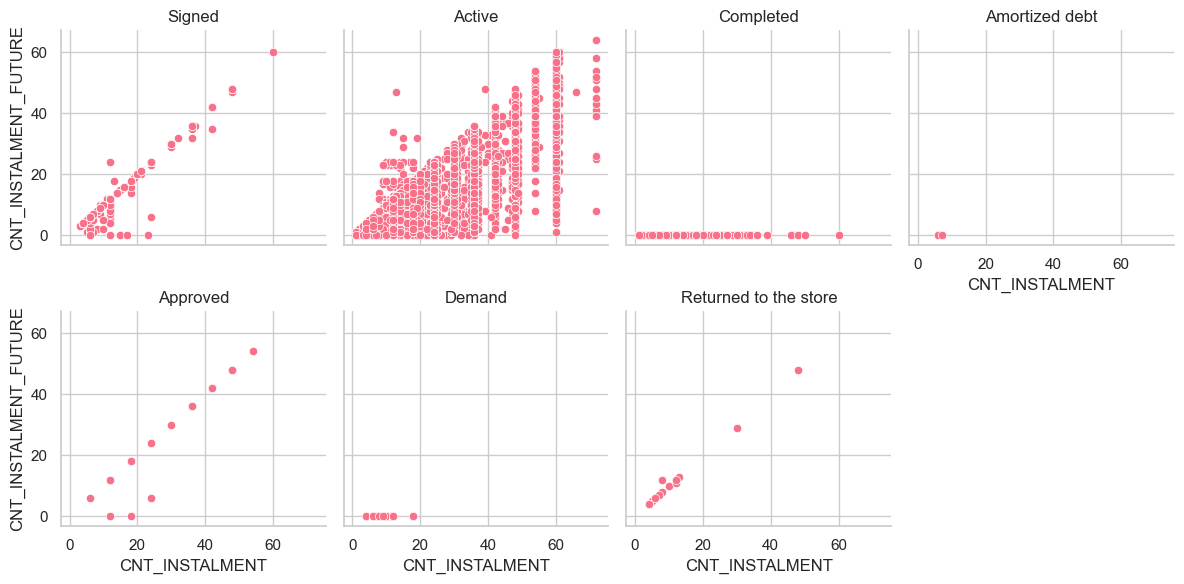

In [9]:
g = sns.FacetGrid(pos_cash_sample, col="NAME_CONTRACT_STATUS", col_wrap=4)
g.map(sns.scatterplot, "CNT_INSTALMENT", "CNT_INSTALMENT_FUTURE")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

plt.show()

Ratio between SK_DPD and SK_DPD_DEF is not a constant when Status is Demand or Amortized debt. Which could suggest Ratio is depicting bad customers.

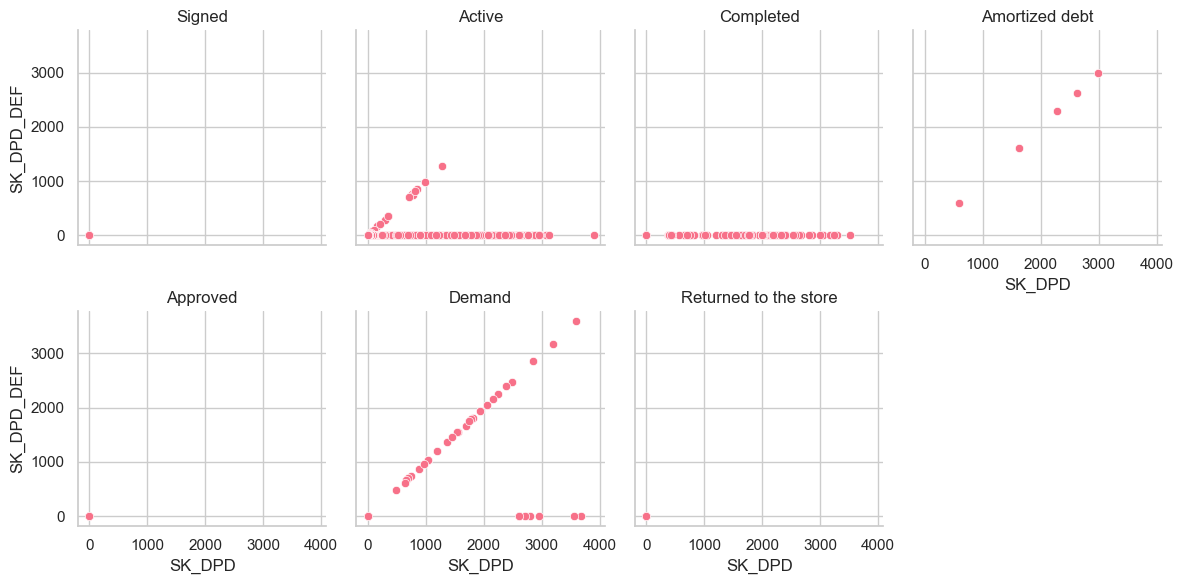

In [10]:
g = sns.FacetGrid(pos_cash_sample, col="NAME_CONTRACT_STATUS", col_wrap=4)
g.map(sns.scatterplot, "SK_DPD", "SK_DPD_DEF")
g.set_titles(col_template="{col_name}", row_template="{row_name}")

plt.show()

As seen in the above graphs, NAME_CONTRACT_STATUS determines balance expectations and behavior. Thus, it can be separated into 2 columns for card activity and risk profile

In [21]:
pos_cash['CARD_ACTIVITY'] = pos_cash['NAME_CONTRACT_STATUS'].apply(
    help_tool.categorize_card_activity)
pos_cash['RISK_PROFILE'] = pos_cash['NAME_CONTRACT_STATUS'].apply(
    help_tool.categorize_risk_profile)

pos_cash.drop(columns=['NAME_CONTRACT_STATUS'], inplace=True)

## Feature engineering
FeatureTools will be used for aggregation, but it can't depict ratios on certain important parameters - installment payed vs not yet payed, missing payments on small vs large loans.

In [25]:
pos_cash[['RATIO_Term_Payed_Left', 'RATIO_DPD']] = duckdb.query("""
    SELECT 
        COALESCE(CAST(CNT_INSTALMENT AS FLOAT) / NULLIF(CNT_INSTALMENT_FUTURE, 0), 0) AS RATIO_Term_Payed_Left,
        COALESCE(CAST(SK_DPD AS FLOAT) / NULLIF(SK_DPD_DEF, 0), 0) AS RATIO_DPD
    FROM pos_cash
""").to_df()

pos_cash.drop(columns=['CNT_INSTALMENT_FUTURE', 'SK_DPD_DEF'], inplace=True)

### Aggregated features with FeatureTools
FeatureTools will aggregate features to sum, mean, man, mix, etc. This is done as it's impossible to guess which of the aggregates will be most useful to model predictions. Instead of guessing, all created features will be applied to Light GBM and filtered based on feature importance.

In [27]:
pos_cash_feature_matrix = help_model.aggregated_features(
    pos_cash.drop(columns=['MONTHS_BALANCE', 'CNT_INSTALMENT']), 'SK_ID_PREV')
pos_cash_feature_matrix.shape

(935435, 28)

## Selecting features
### Target

Only 7% of target is positive

In [29]:
app_pos_cash_feature_matrix = duckdb.query("""  
    SELECT A.*, B.TARGET, B.EXT_SOURCE_1
    FROM pos_cash_feature_matrix A
    INNER JOIN application_train B
    ON A.SK_ID_CURR = B.SK_ID_CURR
  """).to_df()

app_pos_cash_feature_matrix['TARGET'].value_counts(
) / app_pos_cash_feature_matrix['TARGET'].count() * 100

TARGET
0    92.630599
1     7.369401
Name: count, dtype: float64

#### Biserial correlation
Biserial correlation shows no correlation between created features and TARGET.

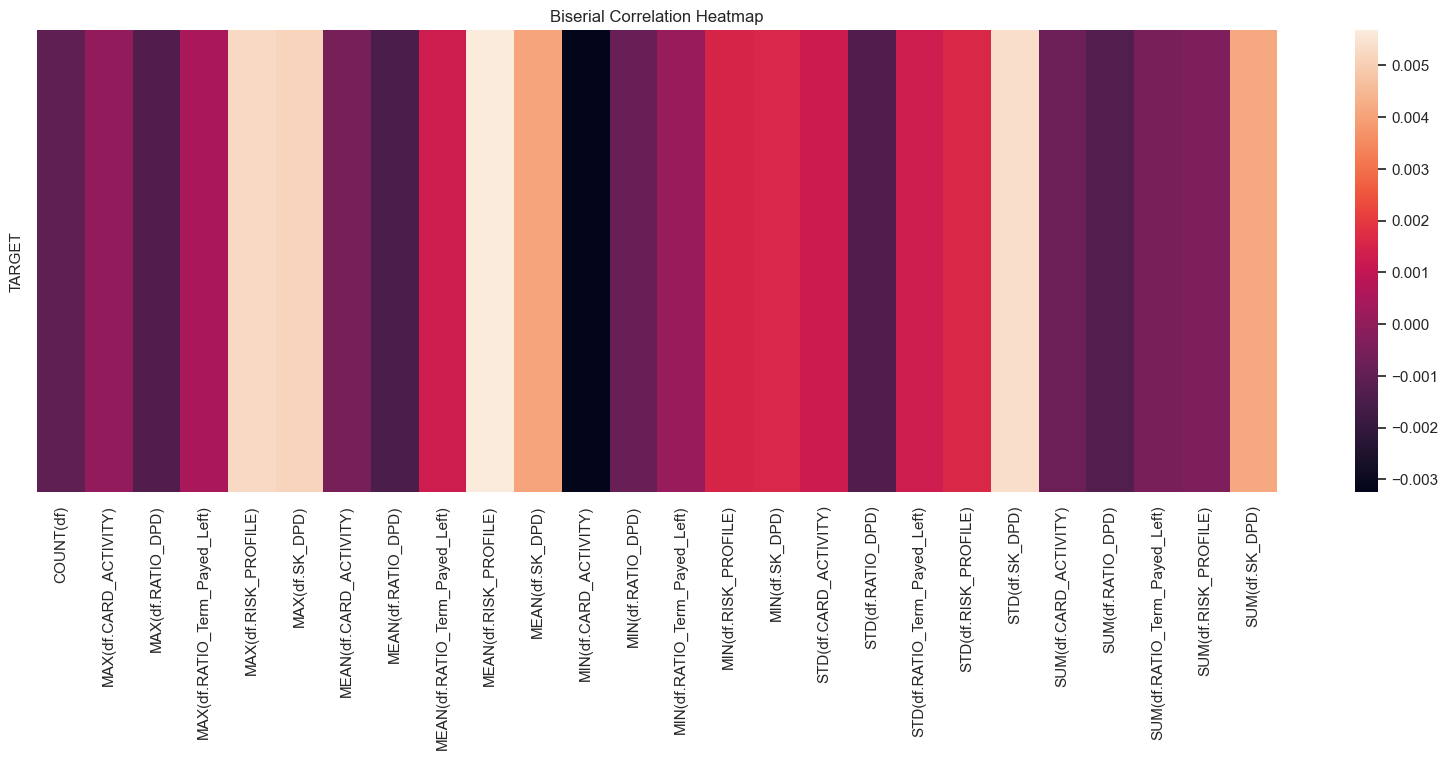

In [33]:
plt.figure(figsize=(20, 6))
help_stats.biserial_heatmap(app_pos_cash_feature_matrix.fillna(-1), app_pos_cash_feature_matrix.drop(
    columns=['SK_ID_PREV', 'SK_ID_CURR', 'TARGET', 'EXT_SOURCE_1']).columns.to_list(), ['TARGET'])

#### Light GBM
High model evaluation metrics are not then goal for feature selection. However, accuracy and recall indicates model preferring only the dominant class (accuracy would reflect the 92% - 7% distribution). 

In this case, Light GBM uses class weights and should have somewhat of a balanced preference to classes. 

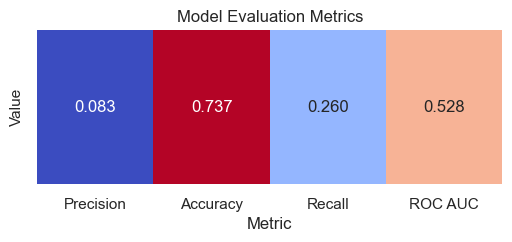

In [36]:
pos_cash_feature_importance = help_model.model_feature_importance_target(
    app_pos_cash_feature_matrix.drop(columns='EXT_SOURCE_1'))

All 'RATIO_Term_Payed_Left' derivatives has a big influence on guessing 'TARGET'. 

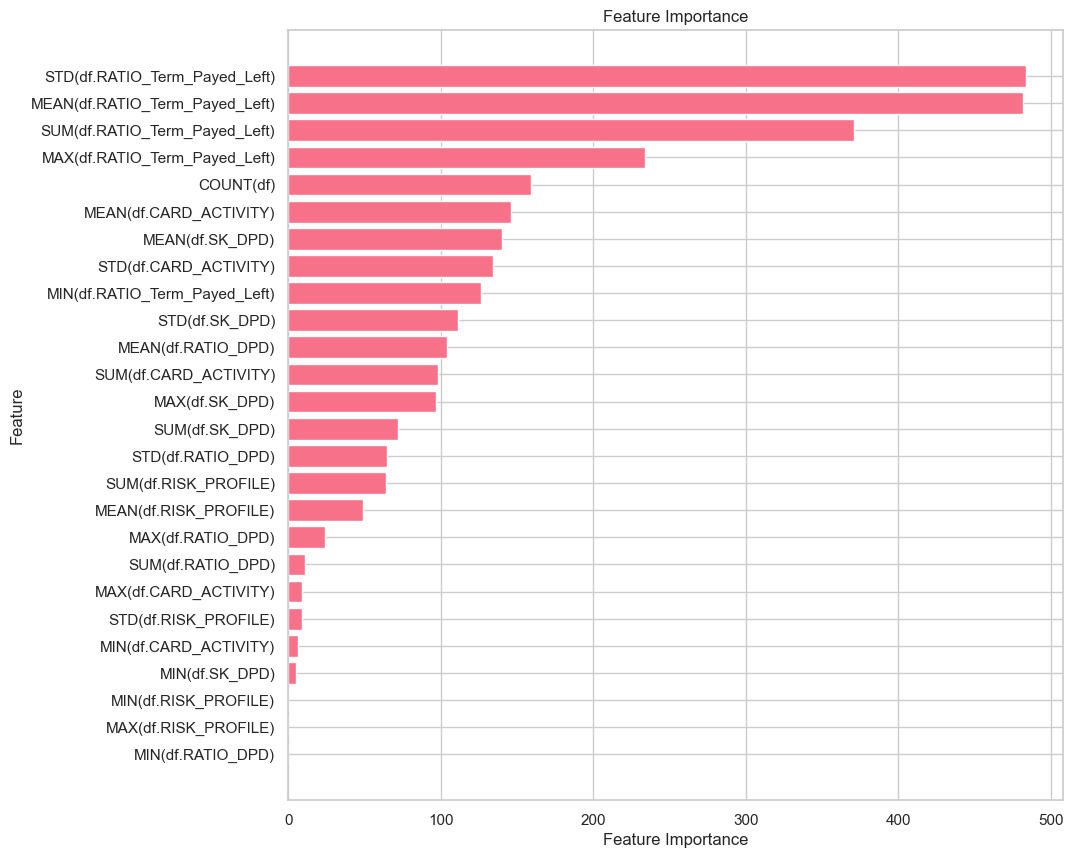

In [38]:
help_model.plot_feature_importance(pos_cash_feature_importance)

#### Top features
Pearson correlation shows 'STD(pos_cash.RATIO_Term_Payed_Left)' and 'SUM(pos_cash.RATIO_Term_Payed_Left)' are not linearly correlated features (among the 'RATIO_Term_Payed_Left)' family).

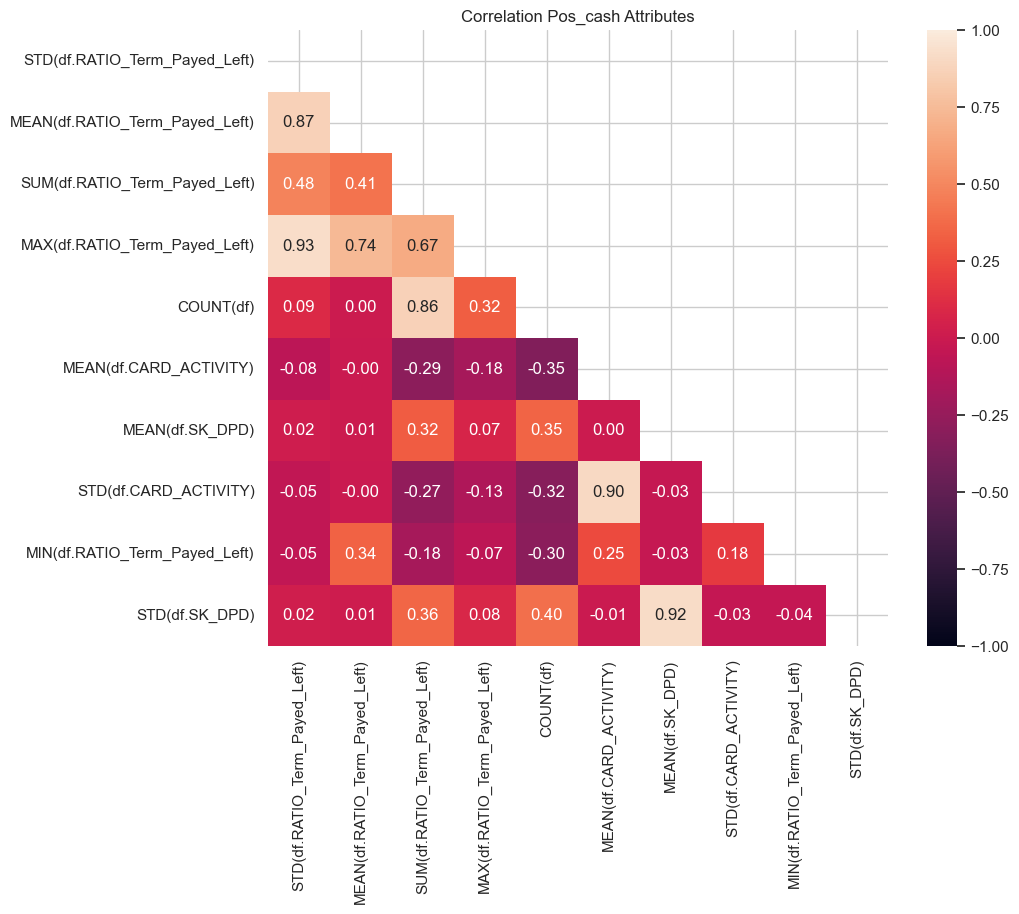

In [41]:
help_visuals.heatmap(app_pos_cash_feature_matrix[pos_cash_feature_importance['feature'].head(
    10).to_list()], 'pos_cash', 'pearson')

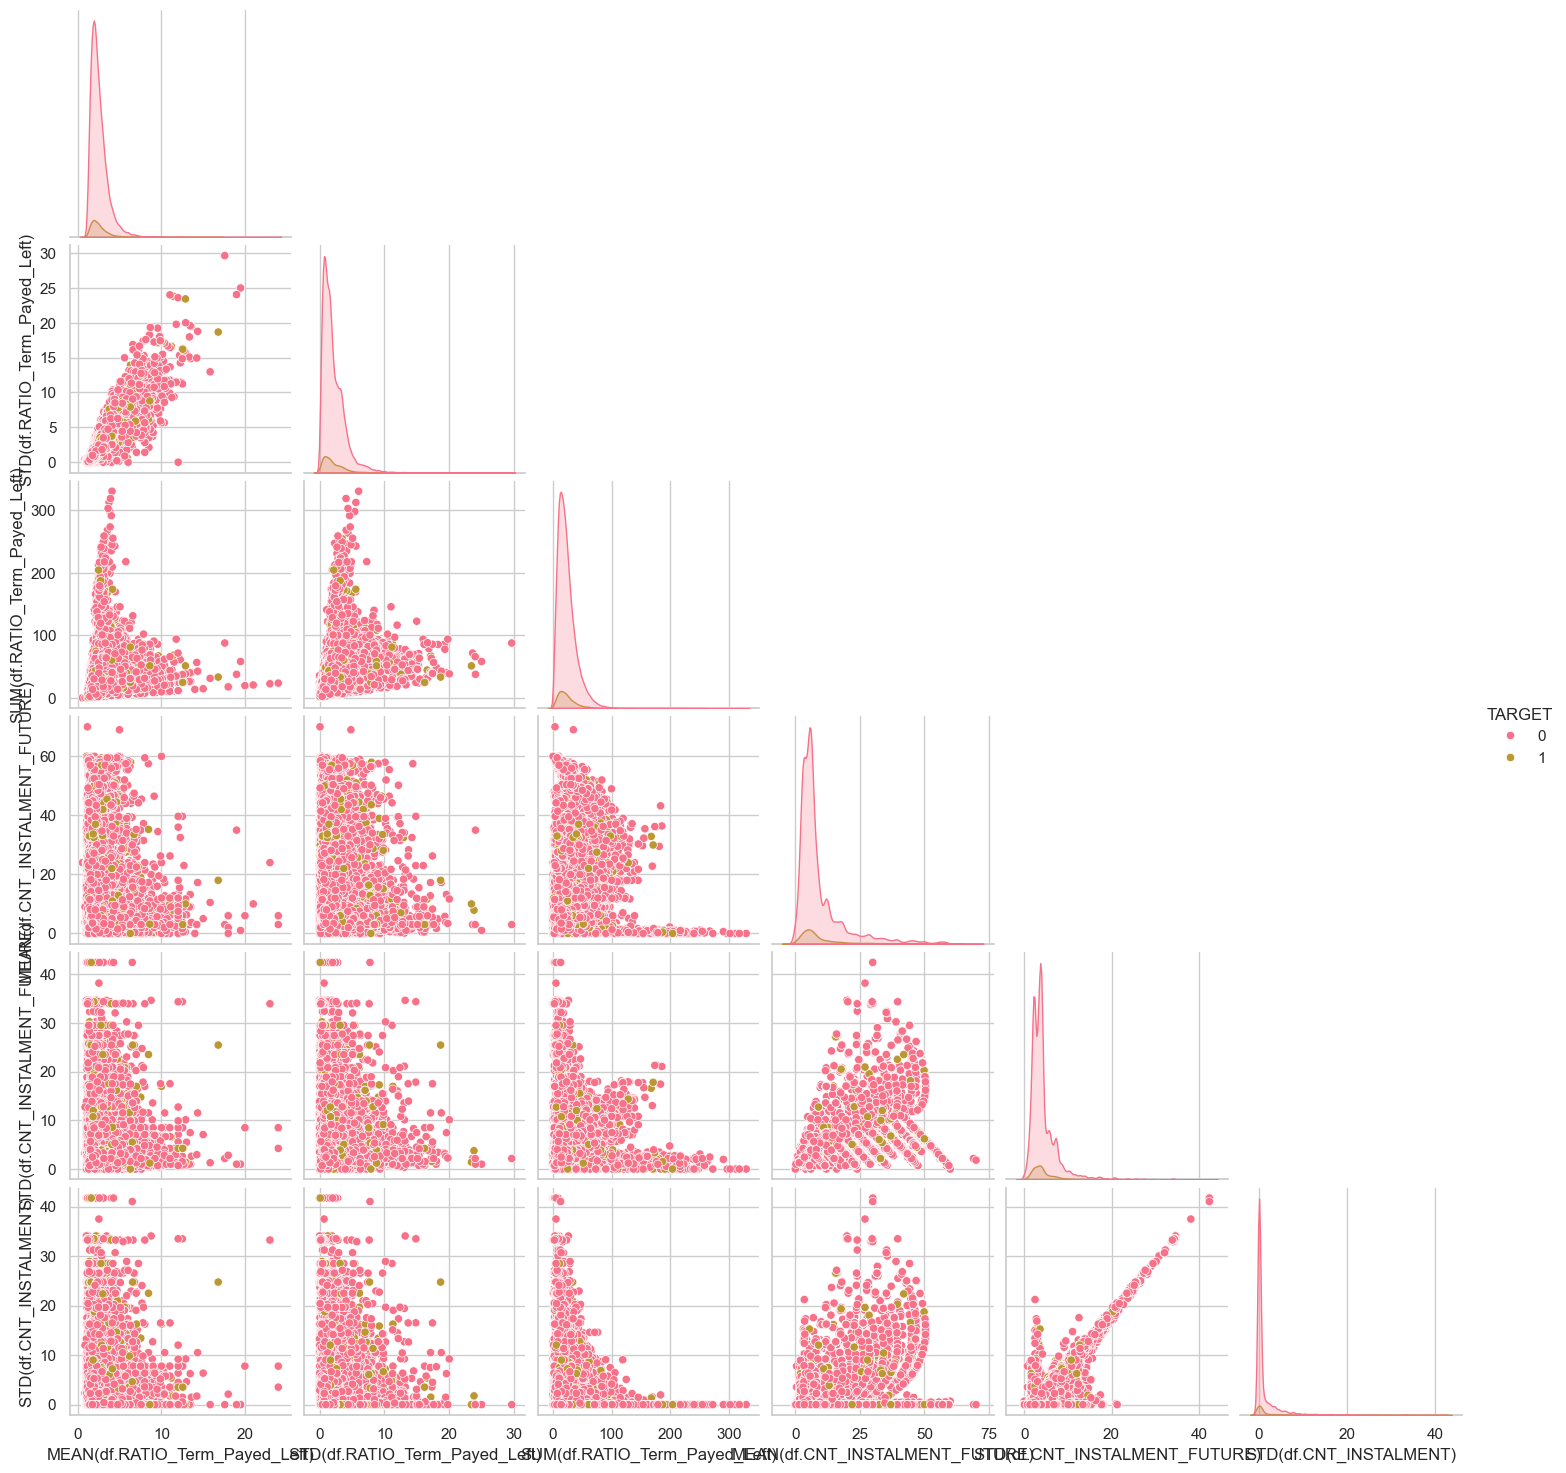

In [24]:
sns.pairplot(app_pos_cash_feature_matrix[pos_cash_feature_importance['feature'].head(
    6).to_list() + ['TARGET']].sample(100000, random_state=42), hue='TARGET', corner=True)
plt.show()

#### Multicollinearity

Multicollinearity can occur in regression analysis when two or more predictor variables are highly correlated to each other. This way they do not provide unique/independent information in the regression model.

Variance Inflation Factor (VIF) = 1/ (1-R^2)

R^2 - coefficient of determination

* VIF = 1, no correlation between the independent variable and the other variables
* VIF above 5 or 10 indicates high Multicollinearity between this independent variable and the others

Variance Inflation Factor (VIF) is specifically designed to detect Multicollinearity. VIF quantifies the severity of Multicollinearity in an ordinary least squares regression analysis. It's calculated by assessing how much the variance of a regression coefficient is inflated due to Multicollinearity in the model.

In [43]:
help_stats.vif(app_pos_cash_feature_matrix[pos_cash_feature_importance['feature'].head(
    6).to_list()].fillna(-1))

variables        VIF
0   STD(df.RATIO_Term_Payed_Left)  29.120718
1  MEAN(df.RATIO_Term_Payed_Left)  21.888103
2   SUM(df.RATIO_Term_Payed_Left)  38.318281
3   MAX(df.RATIO_Term_Payed_Left)  33.814703
4                       COUNT(df)  29.998696
5          MEAN(df.CARD_ACTIVITY)  14.286329

VIF having similar values (29 and 33) signals multicollinearity pair. MEAN(pos_cash.RATIO_Term_Payed_Left) is also strongly linearly correlated (0.91) with STD(pos_cash.RATIO_Term_Payed_Left), only the higher in feature importance will be left in.

#### Finale feature decision
MEAN(df.RATIO_Term_Payed_Left) describes the fluctuation of ratio, between instalments payed and left to pay. It also is correlated with it's feature family. This feature will be used in next steps.

STD(df.RATIO_Term_Payed_Left)


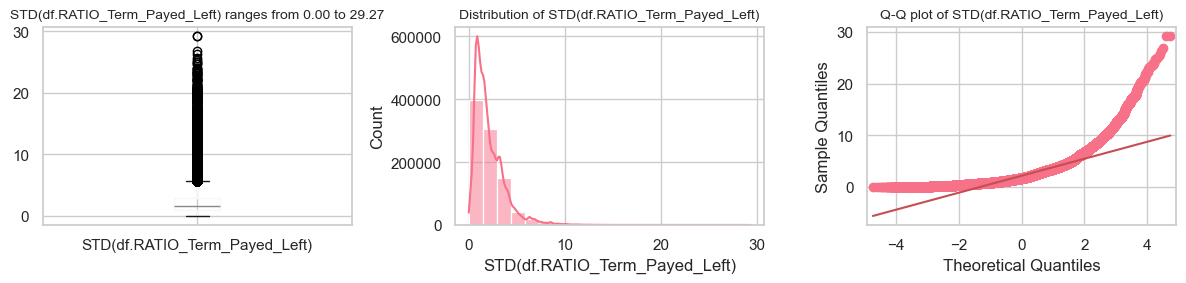

In [58]:
help_visuals.distribution_check(
    pos_cash_feature_matrix[['STD(df.RATIO_Term_Payed_Left)']])

In [72]:
final_check = duckdb.query("""  
    SELECT A.*, B.TARGET, B.EXT_SOURCE_1
    FROM pos_cash_feature_matrix A
    INNER JOIN application_train B
    ON A.SK_ID_CURR = B.SK_ID_CURR
  """).to_df()

Null Hypothesis (H0): There is no relationship between 'STD(df.RATIO_Term_Payed_Left)' and 'TARGET'. <br>
Alternative Hypothesis (H1): There is a relationship between 'STD(df.RATIO_Term_Payed_Left)' and 'TARGET'.

In [73]:
help_stats.significance_t_test(
    final_check, 'STD(df.RATIO_Term_Payed_Left)', 'TARGET', 0, 1)

p-value = nan between STD(df.RATIO_Term_Payed_Left) and TARGET. Fail to reject null hypothesis


#### Conclusion
Despite promising numbers on the Feature importance, selected feature 'STD(df.RATIO_Term_Payed_Left)' is not significantly related to 'TARGET' and won't be used.

### EXT_SOURCE_1
#### Pearson correlation
Pearson correlation also shows no correlation between created features and EXT_SOURCE_1.

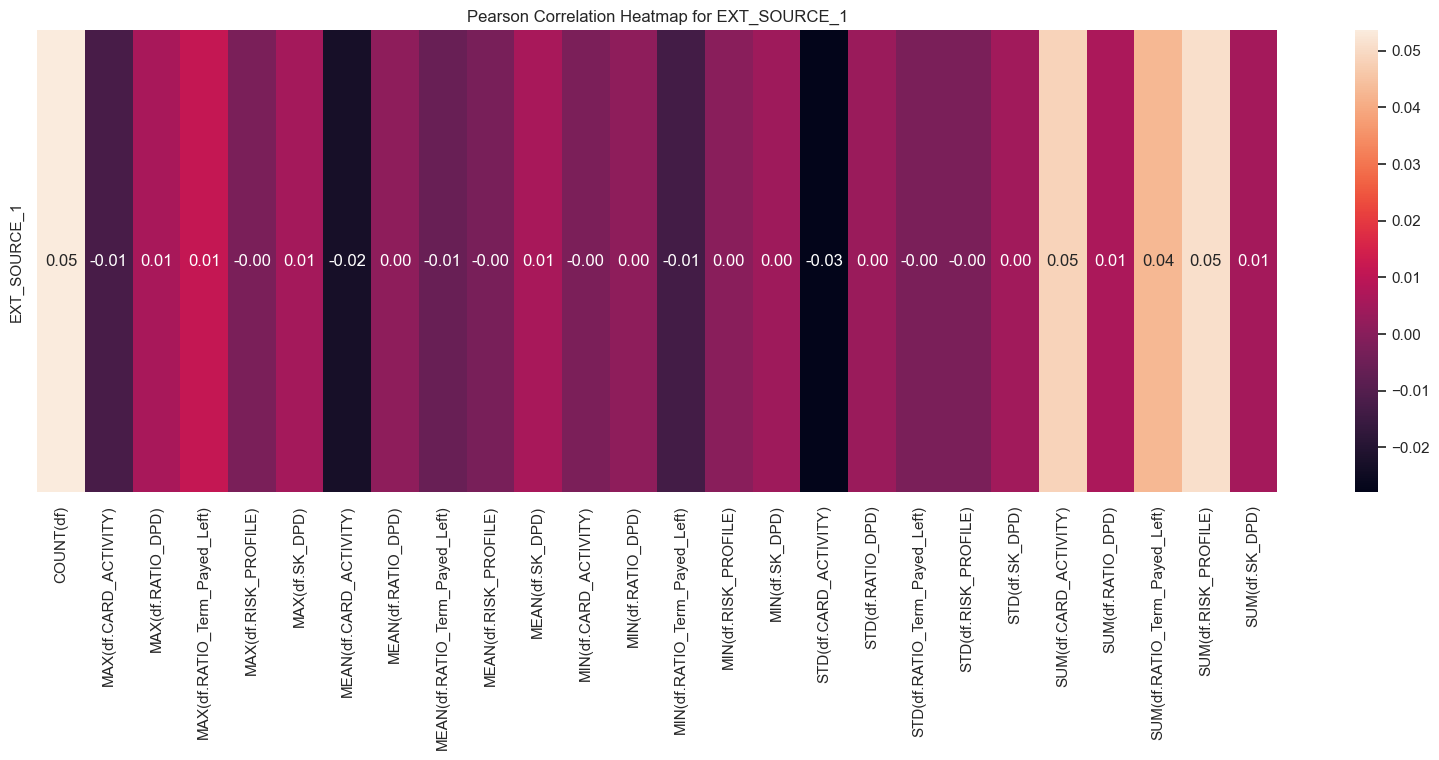

In [69]:
plt.figure(figsize=(20, 6))
help_stats.pearson_heatmap(app_pos_cash_feature_matrix.dropna(subset='EXT_SOURCE_1').fillna(0), app_pos_cash_feature_matrix.drop(
    columns=['SK_ID_PREV', 'SK_ID_CURR', 'TARGET', 'EXT_SOURCE_1']).columns.to_list(), 'EXT_SOURCE_1')

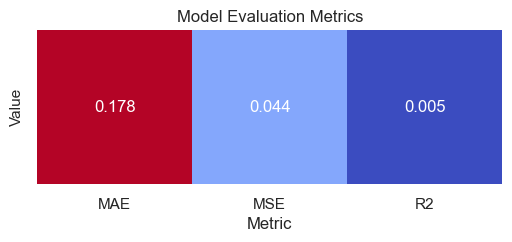

In [70]:
pos_cash_feature_importance = help_model.model_feature_importance_exteranal(
    app_pos_cash_feature_matrix)

EXT_SOURCE_1 has these top features:

In [71]:
pos_cash_feature_importance.head(5)

feature  importance
18   STD(df.RATIO_Term_Payed_Left)         485
8   MEAN(df.RATIO_Term_Payed_Left)         406
23   SUM(df.RATIO_Term_Payed_Left)         368
16           STD(df.CARD_ACTIVITY)         204
3    MAX(df.RATIO_Term_Payed_Left)         201

Null Hypothesis (H0): There is no relationship between 'STD(df.RATIO_Term_Payed_Left)' and 'EXT_SOURCE_1'. <br>
Alternative Hypothesis (H1): There is a relationship between 'STD(df.RATIO_Term_Payed_Left)' and 'EXT_SOURCE_1'.

In [76]:
help_stats.significance_t_test(final_check, 'STD(df.RATIO_Term_Payed_Left)', 'EXT_SOURCE_1',
                               final_check['EXT_SOURCE_1'].min(), final_check['EXT_SOURCE_1'].max())

p-value = 0.7657 between STD(df.RATIO_Term_Payed_Left) and EXT_SOURCE_1. Fail to reject null hypothesis


#### Conclusion
Despite promising numbers on the Feature importance, selected feature 'STD(df.RATIO_Term_Payed_Left)' is not significantly related to 'EXT_SOURCE_1' and won't be used.

# Installments Payments
Installments Payments describes history for the previously disbursed credits in Home Credit related to the loans.
* Dataset has a row for every payment that was made plus a row each for missed payment.
* Dataset has 13 mill. observations and 8 features (all numerical). No duplicates, but information on payment time and amount is missing in some rows.

In [77]:
installments_payments = help_tool.csv_download(
    r'Archive\home-credit-default-risk\installments_payments.csv')
help_tool.first_look(installments_payments)

Dataset has 13605401 observations and 8 features
Columns with all empty values []
Dataset has 0 duplicates


dtypes Null values, Count Null values, %
SK_ID_PREV                int64                  0            0.0
SK_ID_CURR                int64                  0            0.0
NUM_INSTALMENT_VERSION  float64                  0            0.0
NUM_INSTALMENT_NUMBER     int64                  0            0.0
DAYS_INSTALMENT         float64                  0            0.0
DAYS_ENTRY_PAYMENT      float64               2905            0.0
AMT_INSTALMENT          float64                  0            0.0
AMT_PAYMENT             float64               2905            0.0

## Null values
Null values take less than 0%, 2905 rows. Payment day (DAYS_ENTRY_PAYMENT) is missing when payment amount is missing.

In [78]:
installments_payments[installments_payments['DAYS_ENTRY_PAYMENT'].isnull(
) & installments_payments['AMT_PAYMENT'].notna()].shape

(0, 8)

Missing values are safe to drop, as the SK_ID_CURR can be found in non missing rows.

In [79]:
duckdb.query("""
             WITH 
             empty AS (
             SELECT DISTINCT SK_ID_CURR FROM installments_payments
             WHERE DAYS_ENTRY_PAYMENT IS NULL
             )

             ,not_empty AS (
             SELECT DISTINCT SK_ID_CURR FROM installments_payments
             WHERE DAYS_ENTRY_PAYMENT IS NOT NULL
             )

             SELECT *
             FROM empty
             LEFT JOIN not_empty
             ON empty.SK_ID_CURR = not_empty.SK_ID_CURR
             WHERE empty.SK_ID_CURR IS NULL
             """).to_df().shape

(0, 2)

In [80]:
installments_payments = installments_payments[installments_payments['DAYS_ENTRY_PAYMENT'].notna(
) & installments_payments['AMT_PAYMENT'].notna()]

## EDA
Dataset has 8 numerical features
### Numerical Features

NUM_INSTALMENT_VERSION


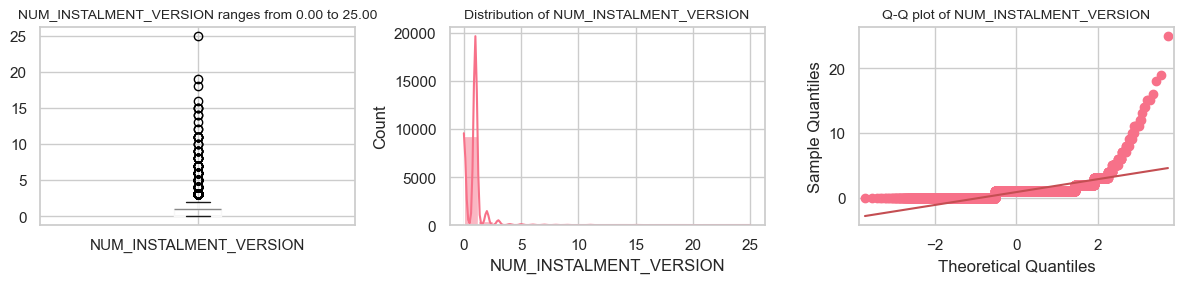

NUM_INSTALMENT_NUMBER


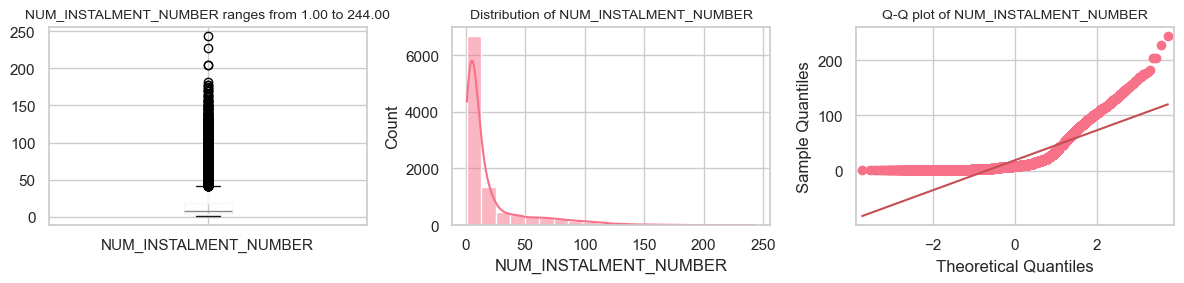

DAYS_INSTALMENT


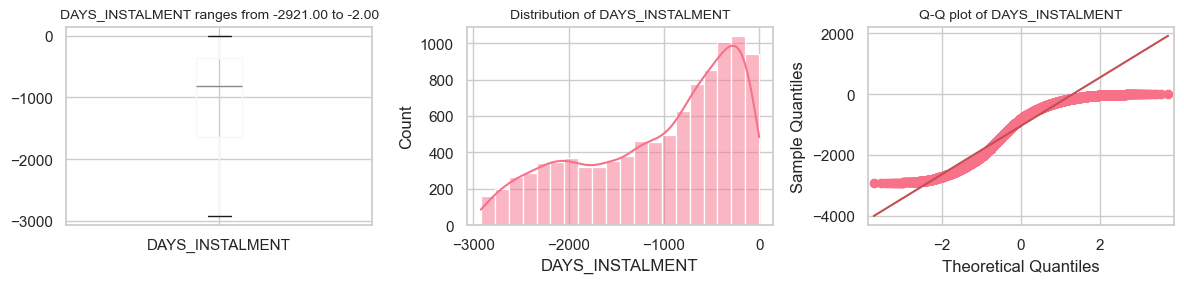

DAYS_ENTRY_PAYMENT


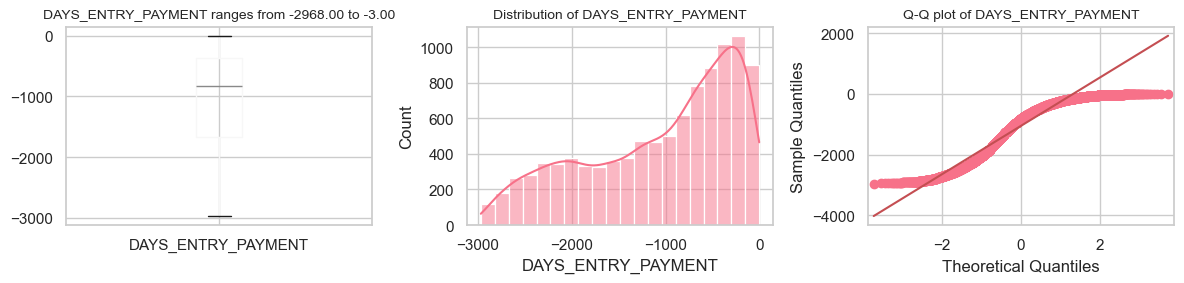

AMT_INSTALMENT


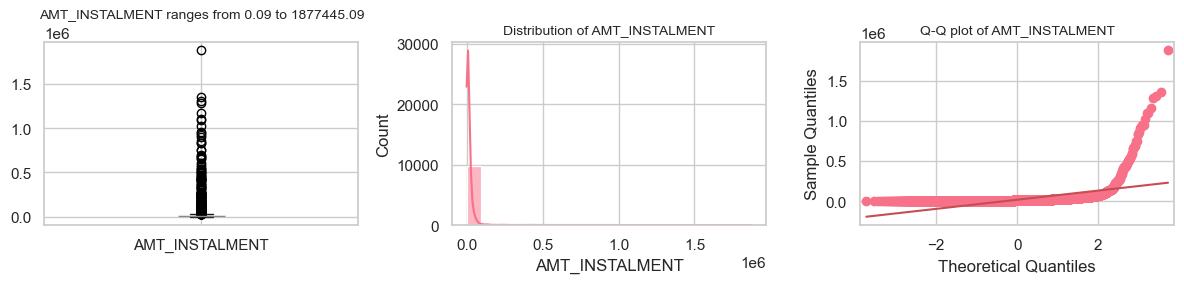

AMT_PAYMENT


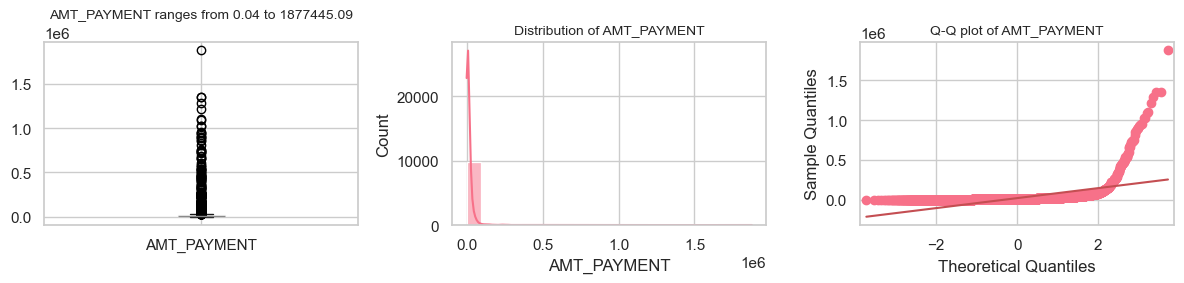

In [82]:
installments_payments_sample = installments_payments.sample(
    10000, random_state=42)
help_visuals.distribution_check(
    installments_payments_sample.drop(columns=['SK_ID_PREV', 'SK_ID_CURR']))

## Feature Engineering
These features are expected to be heavily correlated, as they describe similar aspects of loans:
* Amount expected and payed
* Payment deadline and payment made
Features are useful for ratio description.

In [86]:
installments_payments[['MISSED_DEADLINE_DAYS', 'MISSED_AMT_PAYMENT']] = duckdb.query("""
        SELECT 
            CAST((CAST(DAYS_ENTRY_PAYMENT AS INT) - CAST(DAYS_INSTALMENT AS INT)) AS INT) AS MISSED_DEADLINE_DAYS,
            CAST((CAST(AMT_PAYMENT AS INT) - CAST(AMT_INSTALMENT AS INT)) AS INT) AS MISSED_AMT_PAYMENT
        FROM installments_payments 
""").to_df()

installments_payments.drop(columns=['DAYS_ENTRY_PAYMENT', 'DAYS_INSTALMENT',
                           'AMT_INSTALMENT', 'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER'], inplace=True)

### Aggregated features with FeatureTools

In [90]:
installments_payments_feature_matrix = help_model.aggregated_features(
    installments_payments, 'SK_ID_PREV')
installments_payments_feature_matrix.shape

(997674, 18)

## Selecting features
7% of target is positive

In [91]:
app_installments_payments_feature_matrix = duckdb.query("""  
    SELECT A.*, B.TARGET
    FROM installments_payments_feature_matrix A
    INNER JOIN application_train B
    ON A.SK_ID_CURR = B.SK_ID_CURR
  """).to_df()
app_installments_payments_feature_matrix['TARGET'].value_counts(
) / app_installments_payments_feature_matrix['TARGET'].count() * 100

TARGET
0    92.440447
1     7.559553
Name: count, dtype: float64

### Biserial correlation
Biserial correlation shows no correlation between created features and TARGET.

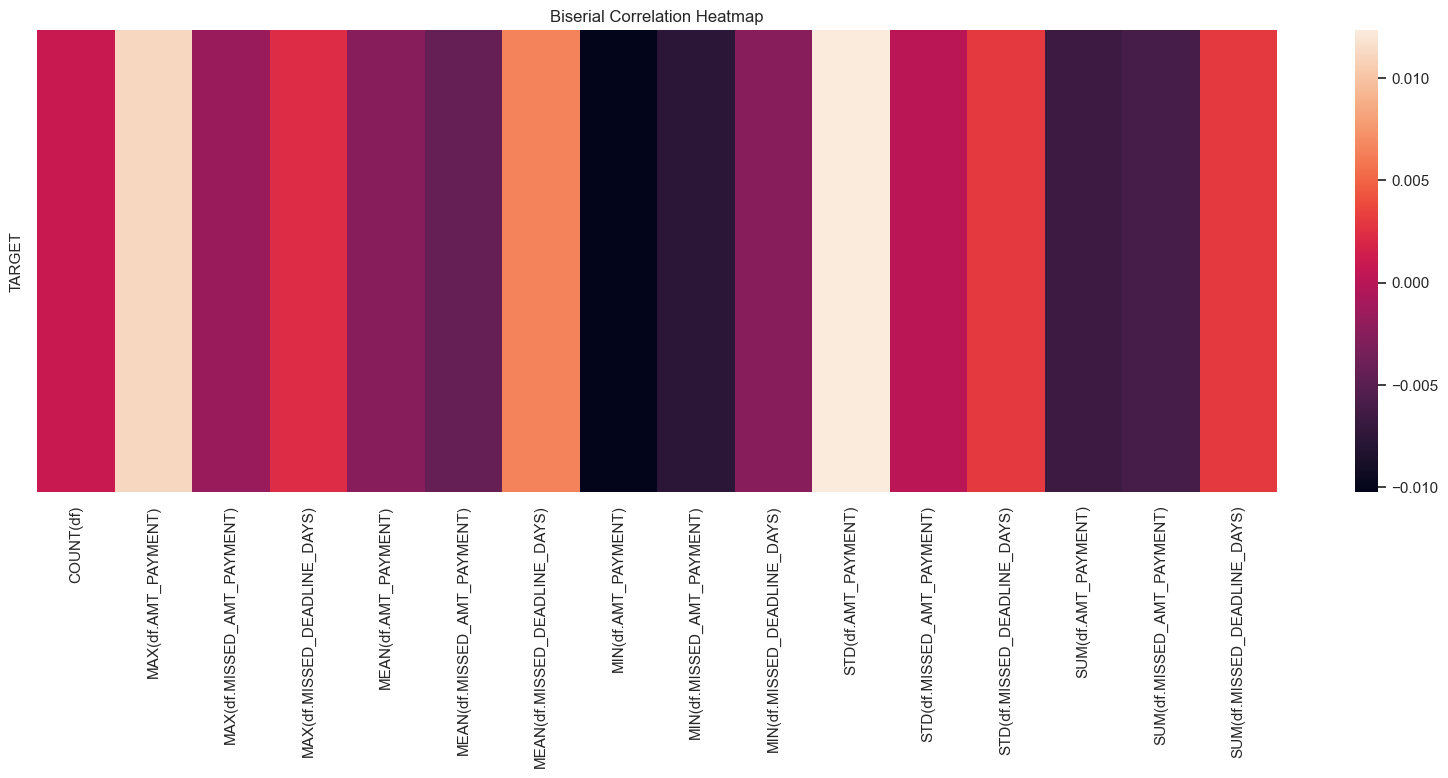

In [92]:
plt.figure(figsize=(20, 6))
help_stats.biserial_heatmap(app_installments_payments_feature_matrix.fillna(-1), app_installments_payments_feature_matrix.drop(
    columns=['SK_ID_PREV', 'SK_ID_CURR', 'TARGET']).columns.to_list(), ['TARGET'])

### Light GBM

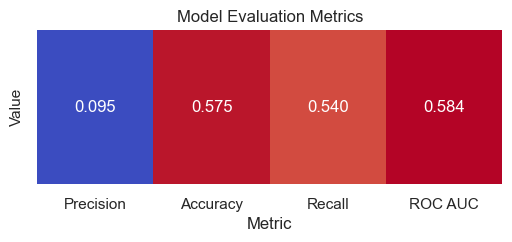

In [93]:
feature_importance_installments_payments = help_model.model_feature_importance_target(
    app_installments_payments_feature_matrix)

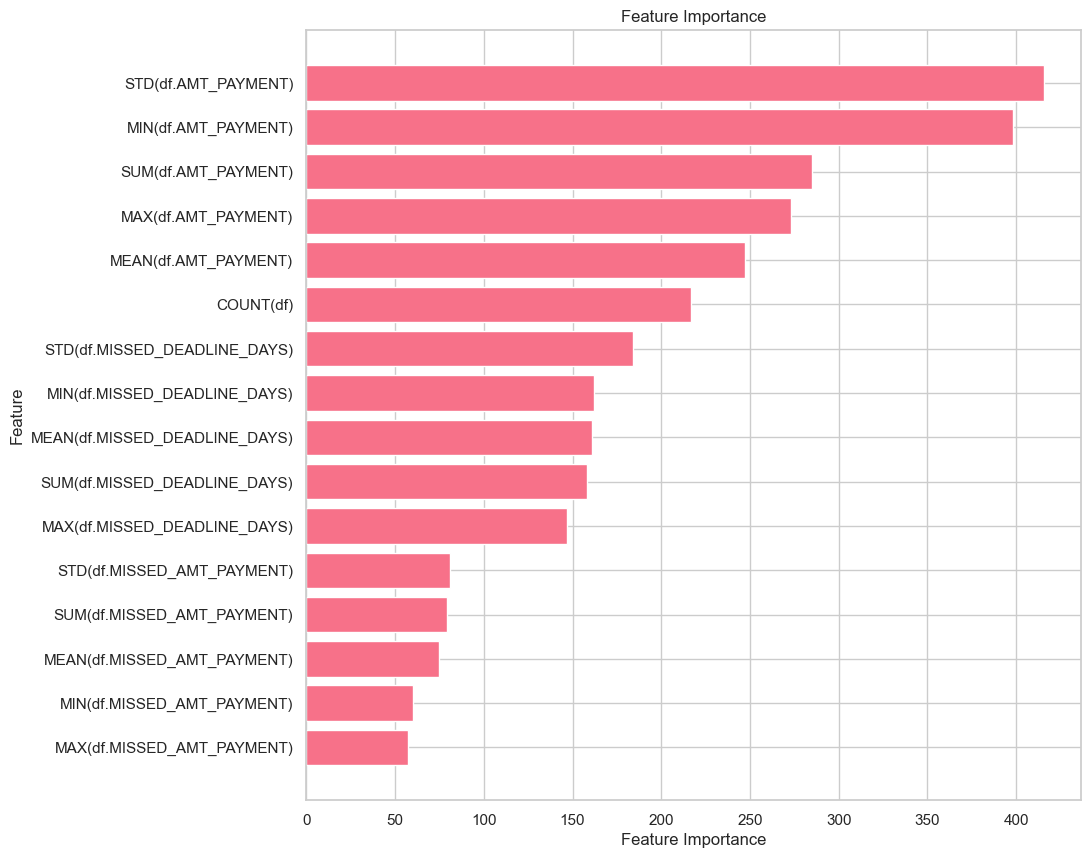

In [94]:
help_model.plot_feature_importance(feature_importance_installments_payments)

### 7 top features are selected
'STD(df.AMT_INSTALMENT)' is correlated with other 'AMT_INSTALMENT' features.

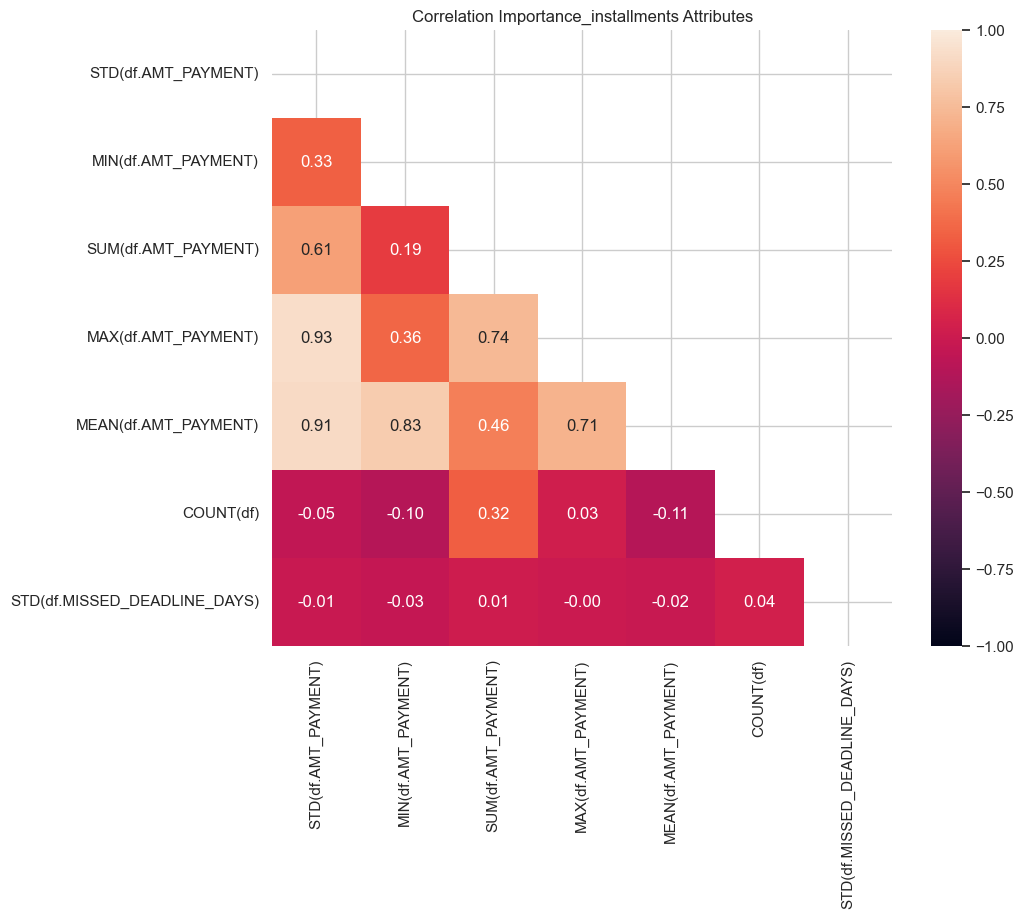

In [95]:
help_visuals.heatmap(app_installments_payments_feature_matrix[feature_importance_installments_payments['feature'].head(
    7).to_list()], 'importance_installments', 'pearson')

### Multicollinearity
No pair is above 5 in VIF, thus the selection is acceptable and K means clustering can be performed without risk of capturing correlation.

In [100]:
installments_payments_selected_features = [
    'STD(df.AMT_PAYMENT)', 'MIN(df.AMT_PAYMENT)', 'SUM(df.AMT_PAYMENT)']

In [101]:
help_stats.vif(
    app_installments_payments_feature_matrix[installments_payments_selected_features].fillna(-1))

variables       VIF
0  STD(df.AMT_PAYMENT)  1.756185
1  MIN(df.AMT_PAYMENT)  1.097958
2  SUM(df.AMT_PAYMENT)  1.881013

## Clustering with K means

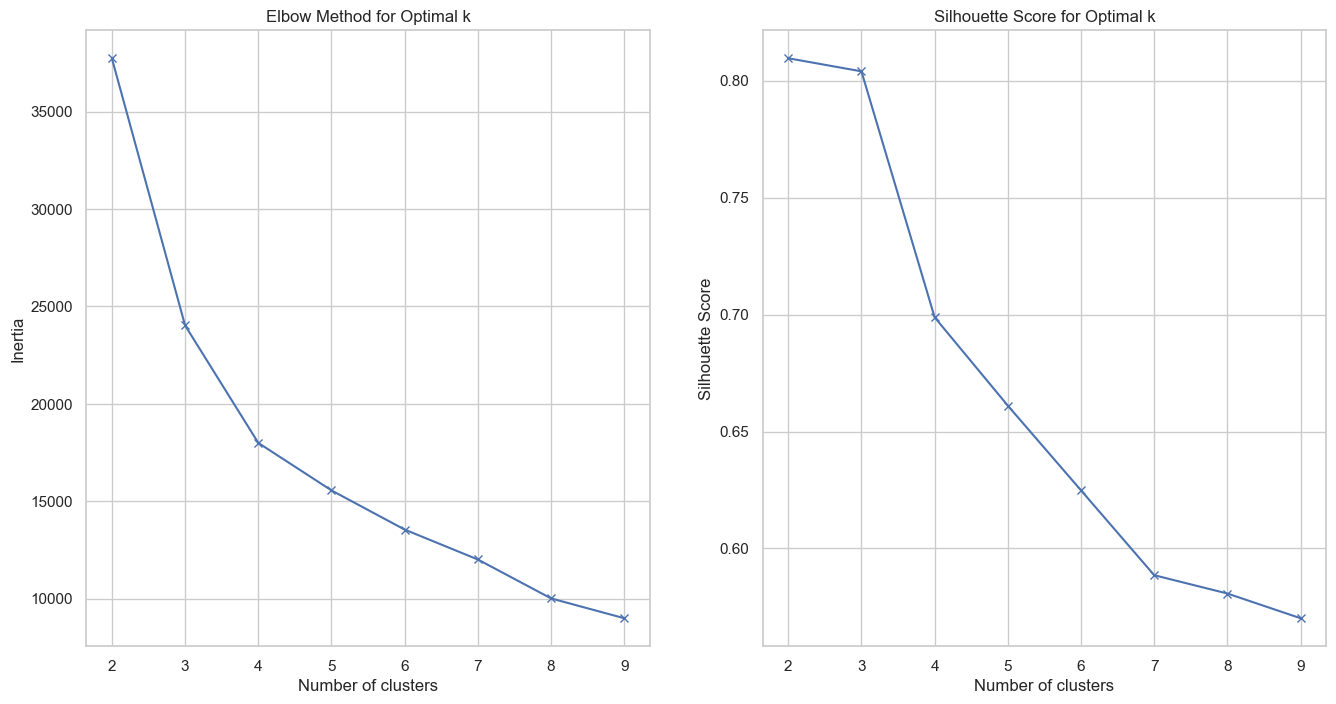

In [104]:
help_model.clustering_k_means_test(app_installments_payments_feature_matrix[installments_payments_selected_features].sample(
    20000, random_state=42).fillna(app_installments_payments_feature_matrix[installments_payments_selected_features].mean()))

Clustering describes payment size, payment changes over time.

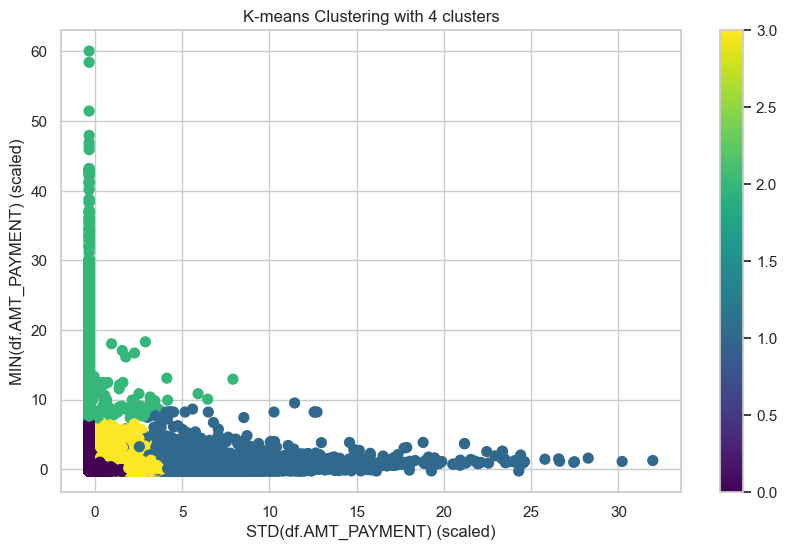

In [105]:
installments_payments_feature_matrix['Cluster_installments_payments'] = help_model.clustering_k_means(
    installments_payments_feature_matrix[installments_payments_selected_features].fillna(app_installments_payments_feature_matrix[installments_payments_selected_features].mean()), 4)

In [106]:
installments_payments_feature_matrix = duckdb.query("""  
    SELECT A.*, B.TARGET
    FROM installments_payments_feature_matrix A
    INNER JOIN application_train B
    ON A.SK_ID_CURR = B.SK_ID_CURR
  """).to_df()

installments_payments_feature_matrix[['Cluster_installments_payments', 'TARGET']].value_counts().sort_index(
) / installments_payments_feature_matrix['Cluster_installments_payments'].value_counts().sort_index() * 100

Cluster_installments_payments  TARGET
0                              0         92.497589
                               1          7.502411
1                              0         91.988389
                               1          8.011611
2                              0         92.587313
                               1          7.412687
3                              0         92.016546
                               1          7.983454
Name: count, dtype: float64

Clusters have similar distribution to TARGET and the whole dataset.

Null Hypothesis (H0): There is no relationship between 'STD(df.AMT_PAYMENT)' and 'TARGET'. <br>
Alternative Hypothesis (H1): There is a relationship between 'STD(df.AMT_PAYMENT)' and 'TARGET'.

In [108]:
help_stats.significance_t_test(
    installments_payments_feature_matrix, 'STD(df.AMT_PAYMENT)', 'TARGET', 0, 1)

p-value = nan between STD(df.AMT_PAYMENT) and TARGET. Fail to reject null hypothesis


Null Hypothesis (H0): There is no relationship between 'Cluster_installments_payments' and 'TARGET'. <br>
Alternative Hypothesis (H1): There is a relationship between 'Cluster_installments_payments' and 'TARGET'.

In [109]:
help_stats.significance_t_test(
    installments_payments_feature_matrix, 'Cluster_installments_payments', 'TARGET', 0, 1)

p-value = 0.0000 between Cluster_installments_payments and TARGET. Reject null hypothesis


## Conclusion
Top feature 'STD(df.AMT_PAYMENT)' has no significant relations with 'TARGET', but 'Cluster_installments_payments' has a significant relationship.

## Exporting grouped dataset

In [110]:
sorted_installments_payments_feature_matrix = installments_payments_feature_matrix[[
    'SK_ID_PREV', 'SK_ID_CURR', 'Cluster_installments_payments']]
sorted_installments_payments_feature_matrix.to_csv(
    r'Archive\home-credit-default-risk\sorted_installments_payments_feature_matrix.csv')

# Credit Card Balance
Credit Card Balance describes balance snapshots of previous credit cards that the applicant has with Home Credit.
* Dataset has a row for each month of history of every previous credit in Home Credit (consumer credit and cash loans).
* Dataset has 3 mill. observations and 23 features (all numerical, except NAME_CONTRACT_STATUS). No duplicates, but information on cash drawings, instalment maturity is missing.

In [40]:
credit_card_balance = help_tool.csv_download(
    r'Archive\home-credit-default-risk\credit_card_balance.csv')
help_tool.first_look(credit_card_balance)

Dataset has 3840312 observations and 23 features
Columns with all empty values []
Dataset has 0 duplicates


dtypes Null values, Count Null values, %
SK_ID_PREV                    int64                  0            0.0
SK_ID_CURR                    int64                  0            0.0
MONTHS_BALANCE                int64                  0            0.0
AMT_BALANCE                 float64                  0            0.0
AMT_CREDIT_LIMIT_ACTUAL       int64                  0            0.0
AMT_DRAWINGS_ATM_CURRENT    float64             749816           19.5
AMT_DRAWINGS_CURRENT        float64                  0            0.0
AMT_DRAWINGS_OTHER_CURRENT  float64             749816           19.5
AMT_DRAWINGS_POS_CURRENT    float64             749816           19.5
AMT_INST_MIN_REGULARITY     float64             305236            7.9
AMT_PAYMENT_CURRENT         float64             767988           20.0
AMT_PAYMENT_TOTAL_CURRENT   float64                  0            0.0
AMT_RECEIVABLE_PRINCIPAL    float64                  0            0.0
AMT_RECIVABLE               float64                  0            0.0
AMT_TOTAL_RECEIVABLE        float64                  0            0.0
CNT_DRAWINGS_ATM_CURRENT    float64             749816           19.5
CNT_DRAWINGS_CURRENT          int64                  0            0.0
CNT_DRAWINGS_OTHER_CURRENT  float64             749816           19.5
CNT_DRAWINGS_POS_CURRENT    float64             749816           19.5
CNT_INSTALMENT_MATURE_CUM   float64             305236            7.9
NAME_CONTRACT_STATUS         object                  0            0.0
SK_DPD                        int64                  0            0.0
SK_DPD_DEF                    int64                  0            0.0

## Null values
AMT_DRAWINGS_ATM_CURRENT has the same NaN values as the rest of AMT_DRAWINGS columns. 

Drawing features for places have missing values, where the total amount is 0.

In [112]:
credit_card_balance[credit_card_balance['AMT_DRAWINGS_ATM_CURRENT'].isna()].filter(
    regex='.*_DRAWINGS_', axis=1).describe()

AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  \
count                       0.0              749816.0   
mean                        NaN                   0.0   
std                         NaN                   0.0   
min                         NaN                   0.0   
25%                         NaN                   0.0   
50%                         NaN                   0.0   
75%                         NaN                   0.0   
max                         NaN                   0.0   

       AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  \
count                         0.0                       0.0   
mean                          NaN                       NaN   
std                           NaN                       NaN   
min                           NaN                       NaN   
25%                           NaN                       NaN   
50%                           NaN                       NaN   
75%                           NaN                       NaN   
max                           NaN                       NaN   

       CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  \
count                       0.0              749816.0   
mean                        NaN                   0.0   
std                         NaN                   0.0   
min                         NaN                   0.0   
25%                         NaN                   0.0   
50%                         NaN                   0.0   
75%                         NaN                   0.0   
max                         NaN                   0.0   

       CNT_DRAWINGS_OTHER_CURRENT  CNT_DRAWINGS_POS_CURRENT  
count                         0.0                       0.0  
mean                          NaN                       NaN  
std                           NaN                       NaN  
min                           NaN                       NaN  
25%                           NaN                       NaN  
50%                           NaN                       NaN  
75%                           NaN                       NaN  
max                           NaN                       NaN

Features AMT_INST_MIN_REGULARITY and CNT_INSTALMENT_MATURE_CUM are depected as NaN when the account was recently activated.

In [41]:
credit_card_balance[credit_card_balance['AMT_INST_MIN_REGULARITY'].isna(
) & credit_card_balance['CNT_INSTALMENT_MATURE_CUM'].notna()].shape

(0, 23)

In [42]:
for feature in credit_card_balance.filter(regex='.*CURRENT', axis=1).columns.to_list():
    credit_card_balance.loc[(credit_card_balance['AMT_DRAWINGS_CURRENT'] == 0)
                            & credit_card_balance[feature].isna(), feature] = 0

credit_card_balance.loc[(credit_card_balance['AMT_PAYMENT_TOTAL_CURRENT'] == 0)
                        & credit_card_balance['AMT_PAYMENT_CURRENT'].isna(), 'AMT_PAYMENT_CURRENT'] = 0

for feature in ['AMT_INST_MIN_REGULARITY', 'CNT_INSTALMENT_MATURE_CUM']:
    credit_card_balance.loc[~credit_card_balance['NAME_CONTRACT_STATUS'].isin(
        ['Demand', 'Active']) & credit_card_balance[feature].isna(), feature] = 0

## EDA
### Numerical Features
Some numerical features are obviously related - Drawing features are derivatives of each other. These features are no use for relation checking.

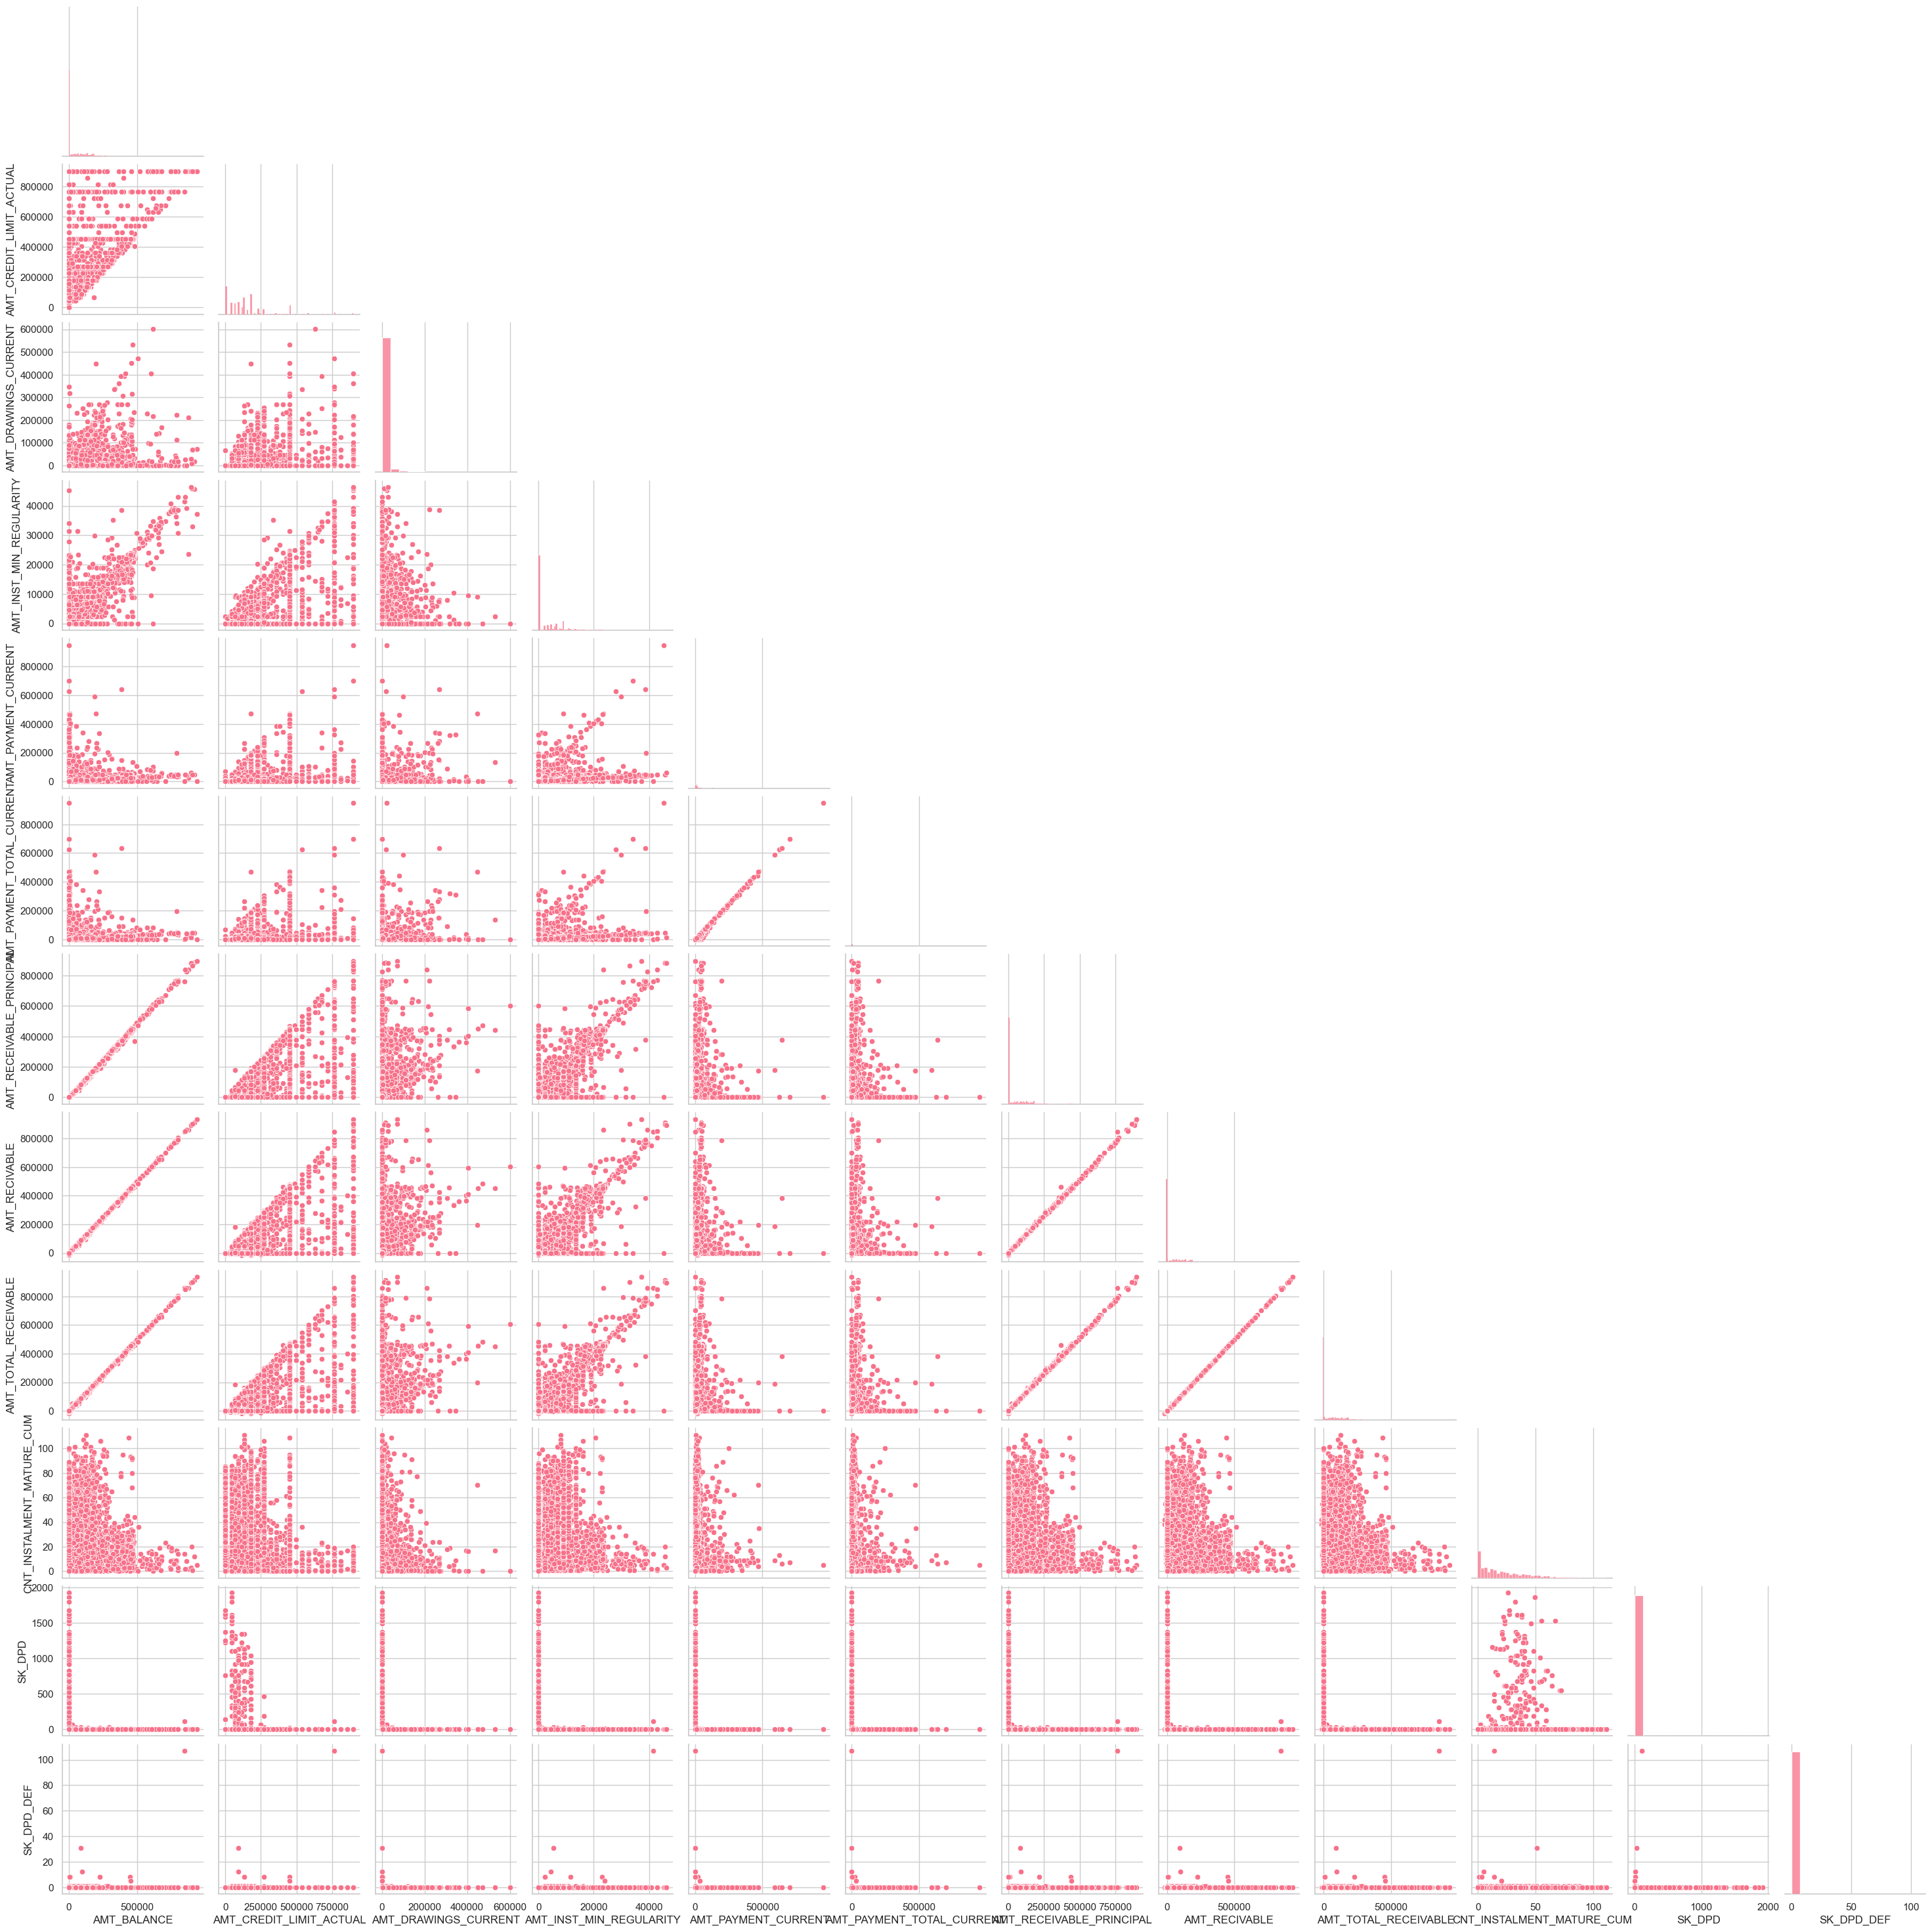

In [120]:
credit_card_balance_sample = credit_card_balance.sample(10000, random_state=42)

sns.pairplot(credit_card_balance_sample.drop(columns=['SK_ID_PREV', 'SK_ID_CURR', 'MONTHS_BALANCE', 'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
                                                      'AMT_DRAWINGS_POS_CURRENT', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
                                                      'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT']), corner=True)

plt.show()

'AMT_BALANCE' is related to 'RECEIVABLE' family. Also, 'AMT_PAYMENT_CURRENT' and 'AMT_PAYMENT_TOTAL_CURRENT' are related.

## Feature Engineering
Adding features for various ratios on limits, utilization, cash drawings, and principle rates. Also, FLAG_ZERO_AMT_BALANCE and FLAG_ZERO_AMT_CREDIT_LIMIT_ACTUAL depict periods of Zero balance or Zero limit.

In [43]:
credit_card_balance['CARD_ACTIVITY'] = credit_card_balance['NAME_CONTRACT_STATUS'].apply(
    help_tool.categorize_card_activity)
credit_card_balance['RISK_PROFILE'] = credit_card_balance['NAME_CONTRACT_STATUS'].apply(
    help_tool.categorize_risk_profile)

credit_card_balance.drop(columns='NAME_CONTRACT_STATUS', inplace=True)

In [44]:
credit_card_balance['FLAG_ZERO_AMT_BALANCE'] = np.where(
    credit_card_balance['AMT_BALANCE'] == 0, 1, 0)

credit_card_balance['FLAG_ZERO_AMT_CREDIT_LIMIT_ACTUAL'] = np.where(
    credit_card_balance['AMT_CREDIT_LIMIT_ACTUAL'] == 0, 1, 0)

In [45]:
credit_card_balance[['Rate_Utilization_Limit', 'Rate_Receivable_Principle',
                     'Rate_Receivable', 'Rate_Receivable_Principle_Total', 'RATIO_DPD',
                     'RATE_INSTALMENT_BALANCE', 'RATE_INST_MIN', 'RATE_DRAWINGS_CURRENT',
                     'RATE_DRAWINGS_ATM_CURRENT', 'RATE_DRAWINGS_OTHER_CURRENT',
                     'RATE_DRAWINGS_POS_CURRENT', 'RATE_RECEIVABLE_1',
                     'RATE_RECEIVABLE_PRINCIPAL', 'RATE_PAYMENT_CURRENT',
                     'RATE_RECEIVABLE_VS_PAYMENT']] = duckdb.query("""



            SELECT 

            (AMT_CREDIT_LIMIT_ACTUAL / AMT_BALANCE) AS Rate_Utilization_Limit,
            (AMT_RECEIVABLE_PRINCIPAL / AMT_BALANCE) AS Rate_Receivable_Principle,
            (AMT_RECIVABLE / AMT_BALANCE) AS Rate_Receivable,
            (AMT_TOTAL_RECEIVABLE / AMT_BALANCE) AS Rate_Receivable_Principle_Total,

            (SK_DPD / SK_DPD_DEF) AS RATIO_DPD,


            (CNT_INSTALMENT_MATURE_CUM / AMT_BALANCE) AS RATE_INSTALMENT_BALANCE,
            (CNT_INSTALMENT_MATURE_CUM / AMT_INST_MIN_REGULARITY) AS RATE_INST_MIN,



            (AMT_DRAWINGS_CURRENT / CNT_DRAWINGS_CURRENT) AS RATE_DRAWINGS_CURRENT,
            (AMT_DRAWINGS_ATM_CURRENT / CNT_DRAWINGS_ATM_CURRENT) AS RATE_DRAWINGS_ATM_CURRENT,
            (AMT_DRAWINGS_OTHER_CURRENT / CNT_DRAWINGS_OTHER_CURRENT) AS RATE_DRAWINGS_OTHER_CURRENT,
            (AMT_DRAWINGS_POS_CURRENT / CNT_DRAWINGS_POS_CURRENT) AS RATE_DRAWINGS_POS_CURRENT,

            (AMT_TOTAL_RECEIVABLE / AMT_RECIVABLE) AS RATE_RECEIVABLE,
            (AMT_RECEIVABLE_PRINCIPAL / AMT_RECIVABLE) AS RATE_RECEIVABLE_PRINCIPAL,

            (AMT_PAYMENT_TOTAL_CURRENT / AMT_PAYMENT_CURRENT) AS RATE_PAYMENT_CURRENT,

            (AMT_PAYMENT_CURRENT / AMT_RECIVABLE) AS RATE_RECEIVABLE_VS_PAYMENT      




            FROM credit_card_balance



""").to_df()

credit_card_balance.drop(columns=['AMT_CREDIT_LIMIT_ACTUAL', 'AMT_RECEIVABLE_PRINCIPAL',
                         'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', 'MONTHS_BALANCE'], inplace=True)

### Aggregated features with FeatureTools

In [46]:
credit_card_balance_feature_matrix = help_model.aggregated_features(
    credit_card_balance, 'SK_ID_PREV')
credit_card_balance_feature_matrix.shape

(104307, 173)

## Selecting features
8% of target is positive

In [50]:
app_credit_card_balance_feature_matrix = duckdb.query("""  
    SELECT A.*, B.TARGET
    FROM credit_card_balance_feature_matrix A
    INNER JOIN application_train B
    ON A.SK_ID_CURR = B.SK_ID_CURR
  """).to_df()

app_credit_card_balance_feature_matrix['TARGET'].value_counts(
) / app_credit_card_balance_feature_matrix['TARGET'].count() * 100

TARGET
0    91.320953
1     8.679047
Name: count, dtype: float64

### Biserial correlation
Biserial correlation shows no correlation between created features and TARGET.

c:\Users\Gintare\anaconda3\envs\model_env\Lib\site-packages\scipy\stats\_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


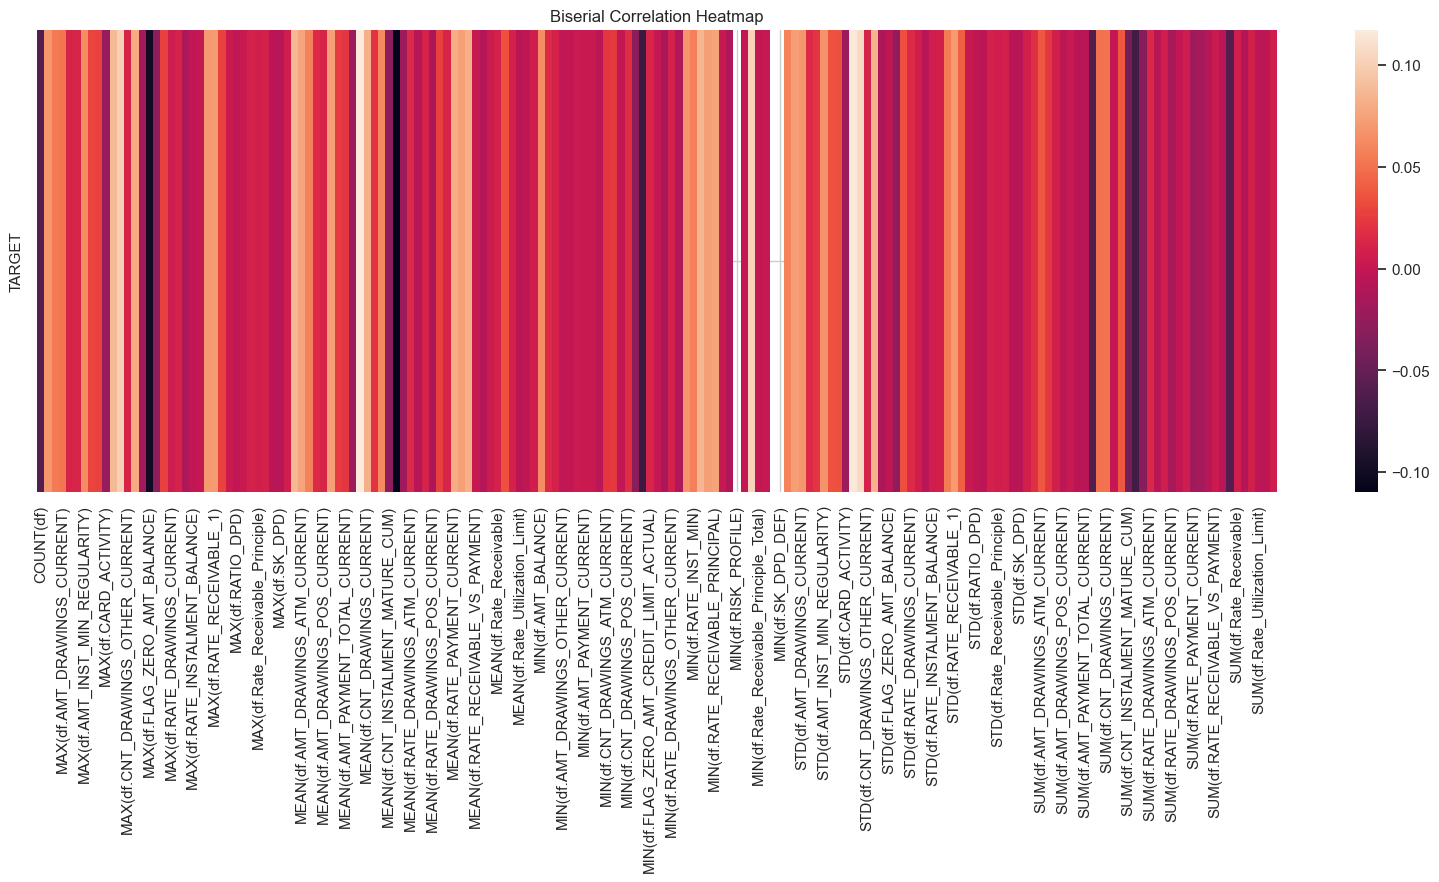

In [51]:
plt.figure(figsize=(20, 6))
help_stats.biserial_heatmap(app_credit_card_balance_feature_matrix.fillna(-1), app_credit_card_balance_feature_matrix.drop(
    columns=['SK_ID_PREV', 'SK_ID_CURR', 'TARGET']).columns.to_list(), ['TARGET'])

### Light GBM

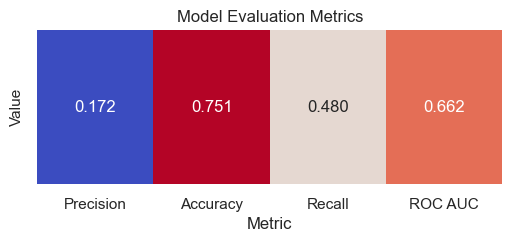

In [52]:
feature_importance_credit_card = help_model.model_feature_importance_target(
    app_credit_card_balance_feature_matrix)

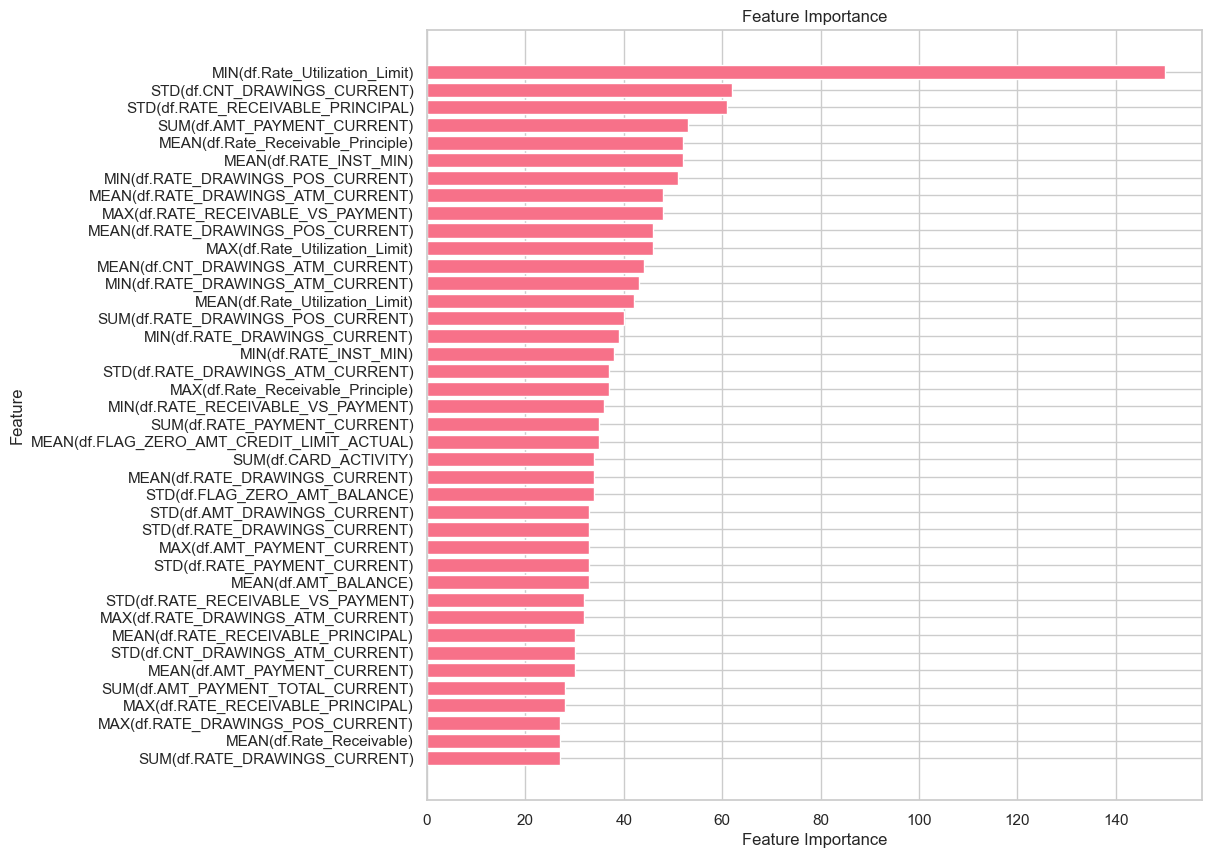

In [53]:
help_model.plot_feature_importance(feature_importance_credit_card.head(40))

Biggest impact comes from Rate_Utilization_Limit

### Top features are selected
No top 6 features are correlated among each other.

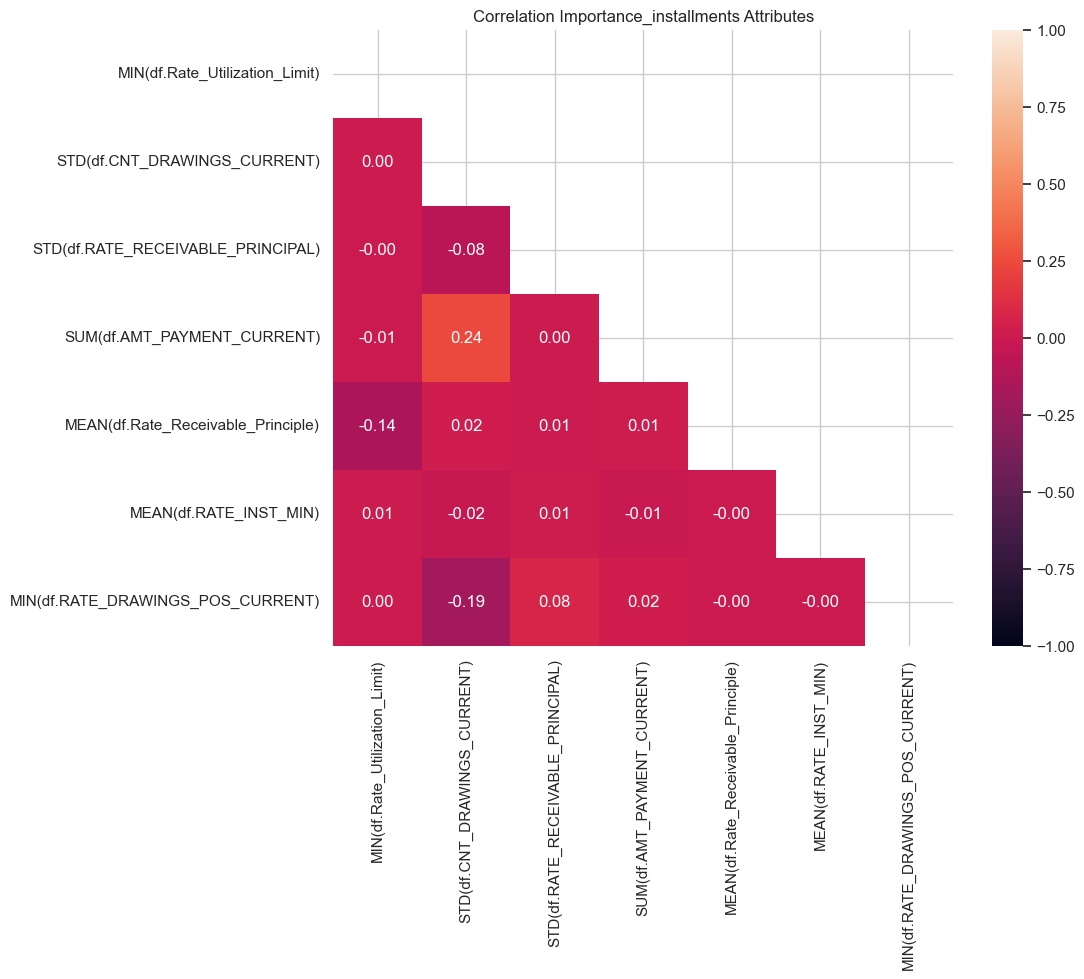

In [54]:
help_visuals.heatmap(app_credit_card_balance_feature_matrix[feature_importance_credit_card['feature'].head(
    7).to_list()], 'importance_installments', 'pearson')

### Multicollinearity
Features have small VIF, it's worth trying to create clusters from this data

In [62]:
credit_card_selected_features = feature_importance_credit_card['feature'].head(
    5).to_list()
help_stats.vif(app_credit_card_balance_feature_matrix[credit_card_selected_features].fillna(
    app_credit_card_balance_feature_matrix[credit_card_selected_features].mean()))

variables       VIF
0      MIN(df.Rate_Utilization_Limit)  1.018749
1        STD(df.CNT_DRAWINGS_CURRENT)  1.269512
2   STD(df.RATE_RECEIVABLE_PRINCIPAL)  1.026493
3         SUM(df.AMT_PAYMENT_CURRENT)  1.295215
4  MEAN(df.Rate_Receivable_Principle)  1.121387

## Clustering with K means

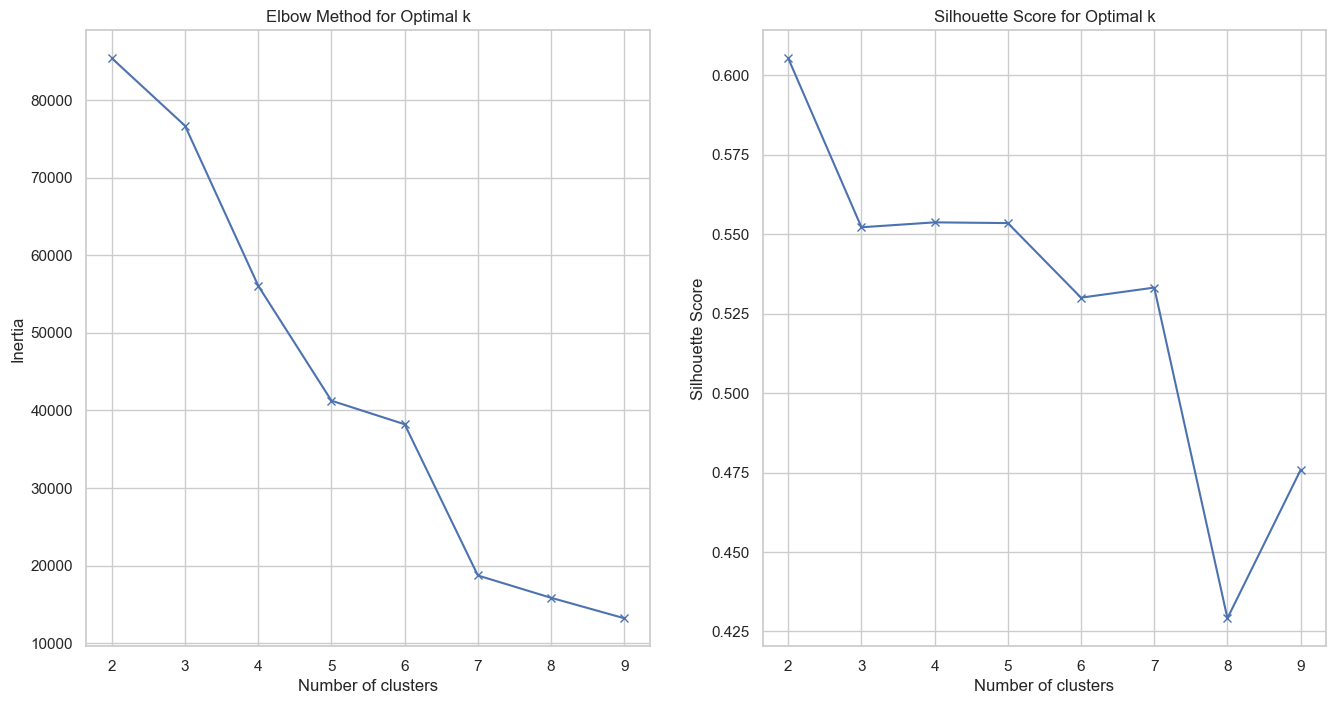

In [57]:
help_model.clustering_k_means_test(app_credit_card_balance_feature_matrix[credit_card_selected_features].sample(
    20000, random_state=42).fillna(app_credit_card_balance_feature_matrix[credit_card_selected_features].mean()))

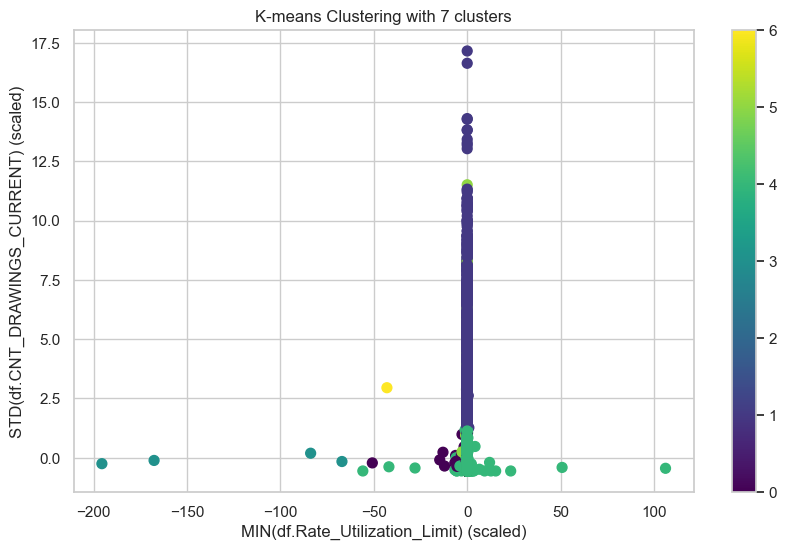

In [58]:
credit_card_balance_feature_matrix['Cluster_credit_card'] = help_model.clustering_k_means(
    credit_card_balance_feature_matrix[credit_card_selected_features].fillna(
        credit_card_balance_feature_matrix[credit_card_selected_features].mean()), 7
)

In [59]:
credit_card_balance_feature_matrix = duckdb.query("""  
    SELECT A.*, B.TARGET
    FROM credit_card_balance_feature_matrix A
    INNER JOIN application_train B
    ON A.SK_ID_CURR = B.SK_ID_CURR
  """).to_df()

Clusters 2 and 3 always distinct 'TARGET' value, while cluster 1 has 17% of '1's.

In [60]:
credit_card_balance_feature_matrix[['Cluster_credit_card', 'TARGET']].value_counts().sort_index(
) / credit_card_balance_feature_matrix['Cluster_credit_card'].value_counts().sort_index() * 100

Cluster_credit_card  TARGET
0                    0          91.879387
                     1           8.120613
1                    0          82.922672
                     1          17.077328
2                    1         100.000000
3                    0         100.000000
4                    0          92.008281
                     1           7.991719
5                    0          92.760181
                     1           7.239819
6                    0         100.000000
Name: count, dtype: float64

## Conclusion
'Cluster_credit_card' has a distinct set of clusters that have different 'TARGET' values and might be handy for value imputing.

## Exporting

In [61]:
sorted_credit_card_balance_feature_matrix = credit_card_balance_feature_matrix[[
    'SK_ID_PREV', 'SK_ID_CURR', 'Cluster_credit_card']]
sorted_credit_card_balance_feature_matrix.to_csv(
    r'Archive\home-credit-default-risk\sorted_credit_card_balance_feature_matrix.csv')

# Conclusion
'Cluster_installments_payments' and 'Cluster_credit_card' have been created as promising features on 'TARGET' imputation.